<a id= 'Table-of-Contents' ></a>
# Table of Contents:
1. [Imports](#Imports)
2. [Read In Data](#Read-In-Data)
3. [Group Values](#Group-Values)
4. [Plotting](#Plotting)
    1. [Capture Times](#Capture-Times)
        1. [Capture Times, No NaN](#Capture-Times-NoNan)
        2. [Capture Times, 120s Cutoff](#Capture-Times-120s)
        3. [Capture Times, 300s Cutoff](#Capture-Times-300s)
    2. [Capture Durations](#Capture-Durations)
        1. [Capture Durations, No NaN](#Capture-Durations-NoNan)
        2. [Capture Durations, 120s Cutoff](#Capture-Durations-120s)
        3. [Capture Durations, 300s Cutoff](#Capture-Durations-300s)
    3. [Latencies](#Latencies)
        1. [Approach Latency, Non NaN](#Approach-Latency-NoNan)
        2. [Approach Latency, 120s Cutoff](#Approach-Latency-120s)
        3. [Approach Latency, 300s Cutoff](#Approach-Latency-300s)
        4. [Intercept Latency, Non NaN](#Intercept-Latency-NoNan)
        5. [Intercept Latency, 120s Cutoff](#Intercept-Latency-120s)
        6. [Intercept Latency, 300s Cutoff](#Intercept-Latency-300s)
    4. [Mouse 0896](#Mouse-0896)
    5. [Mouse 0897](#Mouse-0897)
    6. [Mouse 0898](#Mouse-0898)
    7. [By Session ID](#Session-ID)
    8. [Speed](#Speed)
    9. [Distributions](#Distributions)
        1. [Distributions, 300s Cutoff](#Distributions-300s)
        2. [Distributions, 120s Cutoff](#Distributions-120s)
    10. [Cricket Survival Rate](#Cricket-Survival-Rate)
5. [Stats](#Stats)
    1. [ANOVA](#ANOVA)
    2. [KS-Test](#KS-Test)


<a id= 'Imports' ></a>
# Import all necessary packages and point to the files, current paths for these preliminary analyses point to h5 files on KCC
###### return to [Table of Contents](#Table-of-Contents)

In [273]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from copy import deepcopy as cdc

from datetime import datetime as dt
import re
def extract_timestamps(series:pd.Series) -> pd.Series:
    timestamp = series.str.extract('_(\d{4}-[\-\d_T]*)DLC', expand=False)
    return pd.to_datetime(timestamp, format="%Y-%m-%dT%H_%M_%S")
##need to have filename column as type str in order for datetime extraction to be used, won't run on Posix type

import statsmodels.api as sm
from statsmodels.formula.api import ols

h5_new='/Volumes/molly/20220602alltrials_LD.h5'
h5_old='/Volumes/molly/20220511alltrials_LD.h5'
h5_120s='/Volumes/molly/20220603alltrials_start_LD.h5'

<a id= 'Read-In-Data' ></a>
# Read data into dataframes and create copies (for tossing out failed captures) as well as manipulations for session ID and average speed.
###### return to [Table of Contents](#Table-of-Contents)

#### Use pandas to turn h5 files into dataframes, right now working with df, df old was before newer DLC tracked files were added to the dataset, not really sure what happened with df_120s. This was supposed to be a set of calculations that cut off the data at 120s so it was only the laser on period, but that doesnt appear to have worked.

In [274]:
df=pd.read_hdf(h5_new, key='df')
df_old=pd.read_hdf(h5_old, key='df')
df_120s=pd.read_hdf(h5_120s, key='df')

In [275]:
df

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


#### Save out folder path column of dataframe as file list for other code bases (matlab circle gui etc)

In [716]:
with open('folderlist.txt', 'w') as f_out:
    f_out.write('\n'.join(df['folder_path'].astype('str')))

In [109]:
df_old

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",198.720,0.050321,6.185,0.400000,0.250000
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000


In [162]:
df_120s

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept
0,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[14.012931903926157, 16.45841103998438, 19.185...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",69.945,0.196893,0.175,0.777778,0.071429,7.910
1,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[23.304233769804583, 23.513995388021904, 23.57...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[10.771332386653675, 11.611506992090918, 12.79...","[173.79578078788444, 168.32853083358958, 168.3...",69.310,0.237781,0.730,0.277778,0.200000,12.850
2,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[21.715381070777248, 21.721281588786553, 21.72...","[0.36074291483611154, 0.7115064917078303, 0.80...","[0.16767258394997434, 0.1256581066396896, 0.21...","[148.76262093536454, 148.38440970340278, 148.3...",119.995,0.075000,6.185,0.444444,0.250000,9.675
4,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.41138057161378183, 0.5378076393260555, 0.72...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",46.695,0.103078,0.165,0.285714,0.500000,0.610
5,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[8.876253093269236, 9.447072818341788, 9.96988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",27.495,0.212834,5.750,1.000000,0.100000,6.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[3.5382088253352006, 3.5579035878841205, 3.516...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",34.945,0.277598,0.060,0.333333,0.200000,4.730
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040


#### Set data type for the filename column of the df so it can be accessed correctly to segment the df for later analysis

In [6]:
df['filename']=df['filename'].astype('str')
type(df['filename'][0])

str

In [163]:
df_120s['filename']=df_120s['filename'].astype('str')

#### Create a new df with values over 300s removed in order to toss out failed captures.

In [163]:
nandf=cdc(df)
nans=np.where(nandf['captureT']>=300)
nanvals=nandf['captureT'].iloc[nans[0]]
nandf=nandf.replace({'captureT':nanvals.values}, np.nan)

#### Calculate capture duration as defined in Zhao et al 2019 from already calculated capture time and time to first contact. Add these values to the dataframe.

In [278]:
df['capduration']=df['captureT']-df['timetointercept']

In [276]:
nandf['capduration']=nandf['captureT']-nandf['timetointercept']

In [626]:
df_120s['capduration']=df_120s['captureT']-df_120s['timetointercept']

#### Create a new df with values over 120s removed in order to toss out failed captures.

In [172]:
nandf120=cdc(df)
nans=np.where(nandf120['captureT']>=120)
nanvals=nandf120['captureT'].iloc[nans[0]]
nandf120=nandf120.replace({'captureT':nanvals.values}, np.nan)
nandf120['capduration']=nandf120['captureT']-nandf120['timetointercept']

#### Series of manipulations to the df to order the sessions within each light, food and laser condition, as well as to generate mean speeds for each trial. Going forward need to index the speeds to calculate approach speed, but as of now have mean speed for each trial. 

In [589]:
condition1_0=np.arange(0,105)
condition1_1=np.arange(0,103)
condition2_0=np.arange(0,120)
condition2_1=np.arange(0,114)
condition3_0=np.arange(0,59)
condition3_1=np.arange(0,59)
condition4_0=np.arange(0,81)
condition4_1=np.arange(0,55)

ids=np.concatenate([condition1_0,condition1_1,condition2_0,condition2_1,condition3_0,condition3_1,condition4_0,condition4_1])

In [582]:
copydf=cdc(df)
copydf['timestamps']=extract_timestamps(copydf['filename'])
copydf=copydf.sort_values(by=['condition', 'laser_value','timestamps'])
copydf['sessionID']=ids
copydf

,filename,folder_path,condition,laser_value,dist,cricket_spd,mouse_spd,az,captureT,freqapproach,timetoapproach,prob_inter,prob_capture,timetointercept,capduration,timestamps,sessionID
71,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, 9.988...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",24.740,0.241513,0.210,0.888889,0.125000,2.315,22.425,2022-02-22 08:09:38,0
73,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.9435794273233826, 2.3150358818697847, 2.623...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3.950,0.105876,0.900,1.000000,0.333333,1.475,2.475,2022-02-22 08:22:39,1
74,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.5840676417588357, 1.5447335323554987, 1.731...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",15.035,0.107831,3.290,0.666667,0.500000,5.540,9.495,2022-02-22 08:24:46,2
75,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.0990857586588967, 1.8790604197626206, 1.063...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",26.765,0.182732,0.260,0.571429,0.250000,1.090,25.675,2022-02-22 08:32:47,3
76,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-02-2...,Condition1,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[4.504542091130307, 4.687903667629036, 4.95473...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",86.640,0.166806,0.265,0.411765,0.142857,1.870,84.770,2022-02-22 08:35:13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.279324311771368, 1.241758894488447, 1.30658...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1.250,0.022632,0.230,1.000000,1.000000,1.145,0.105,2022-04-15 09:04:34,50
737,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[1.462482842239078, 1.488112138526609, 1.60963...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",21.560,0.116225,12.000,0.600000,0.333333,19.280,2.280,2022-04-15 09:26:51,51
738,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12.066814973701607, 13.87237568286862, 16.108...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",14.180,0.131527,2.475,0.400000,0.500000,11.800,2.380,2022-04-15 09:30:48,52
739,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,/mnt/ion-nas/Rig4/Molly/ZIActivation/2022-04-1...,Condition4,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.5426251488004638, 0.6258404237519565, 0.650...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",4.095,0.021708,2.490,1.000000,1.000000,4.040,0.055,2022-04-15 09:34:46,53


In [611]:
speedtest=copydf[['condition', 'mouse_spd', 'laser_value', 'sessionID']]
newtest= speedtest.explode('mouse_spd').reset_index().rename(columns={'index':'trial'})
meanspeed= newtest.groupby(['condition','trial', 'laser_value']).agg({'mouse_spd':np.nanmean})
meanspeed=meanspeed.reset_index()
meanspeed

,condition,trial,laser_value,mouse_spd
0,Condition1,0,0.0,10.951588
1,Condition1,1,0.0,12.884350
2,Condition1,2,0.0,4.742795
3,Condition1,4,0.0,10.143461
4,Condition1,5,0.0,9.198848
...,...,...,...,...
691,Condition4,735,1.0,19.637307
692,Condition4,737,1.0,15.457042
693,Condition4,738,1.0,10.897887
694,Condition4,739,1.0,10.996513


#### Bunch of (probably unnecessary, but can be cleaned up later) dataframe manipulations to make things more digestable/ easy to work with for the testing of distribution plotting. This first set works with data with a cutoff of 300s.

In [306]:
test=nandf[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]

In [307]:
cond1=test.query('condition == "Condition1"')
cond2=test.query('condition == "Condition2"')
cond3=test.query('condition == "Condition3"')
cond4=test.query('condition == "Condition4"')

In [326]:
cond1_off=cond1.iloc[np.where(cond1['laser_value']==0)]
cond1_on=cond1.iloc[np.where(cond1['laser_value']==1)]

cond2_off=cond2.iloc[np.where(cond2['laser_value']==0)]
cond2_on=cond2.iloc[np.where(cond2['laser_value']==1)]

cond3_off=cond3.iloc[np.where(cond3['laser_value']==0)]
cond3_on=cond3.iloc[np.where(cond3['laser_value']==1)]

cond4_off=cond4.iloc[np.where(cond4['laser_value']==0)]
cond4_on=cond4.iloc[np.where(cond4['laser_value']==1)]

#### Subsetting the 120s df generated from a separate h5 file.

In [661]:
### This is the df loaded from the h5 file that was supposed to have a cut off at 120s, still not entirely sure what happened with this one
### Need to double check how this cutoff was done, don't think it quite worked
test120=df_120s[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]
cond1_120=test120.query('condition == "Condition1"')
cond2_120=test120.query('condition == "Condition2"')
cond3_120=test120.query('condition == "Condition3"')
cond4_120=test120.query('condition == "Condition4"')

In [662]:
cond1_120off=cond1_120.iloc[np.where(cond1_120['laser_value']==0)]
cond1_120on=cond1_120.iloc[np.where(cond1_120['laser_value']==1)]

cond2_120off=cond2_120.iloc[np.where(cond2_120['laser_value']==0)]
cond2_120on=cond2_120.iloc[np.where(cond2_120['laser_value']==1)]

cond3_120off=cond3_120.iloc[np.where(cond3_120['laser_value']==0)]
cond3_120on=cond3_120.iloc[np.where(cond3_120['laser_value']==1)]

cond4_120off=cond4_120.iloc[np.where(cond4_120['laser_value']==0)]
cond4_120on=cond4_120.iloc[np.where(cond4_120['laser_value']==1)]

#### Subsetting the 120s df generated from manually (within this notebook) going and removing longer capture times like how it was done with 300s

In [663]:
newtest120=nandf_120[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]
newcond1_120=newtest120.query('condition == "Condition1"')
newcond2_120=newtest120.query('condition == "Condition2"')
newcond3_120=newtest120.query('condition == "Condition3"')
newcond4_120=newtest120.query('condition == "Condition4"')

In [664]:
newcond1_120off=newcond1_120.iloc[np.where(newcond1_120['laser_value']==0)]
newcond1_120on=newcond1_120.iloc[np.where(newcond1_120['laser_value']==1)]

newcond2_120off=newcond2_120.iloc[np.where(newcond2_120['laser_value']==0)]
newcond2_120on=newcond2_120.iloc[np.where(newcond2_120['laser_value']==1)]

newcond3_120off=newcond3_120.iloc[np.where(newcond3_120['laser_value']==0)]
newcond3_120on=newcond3_120.iloc[np.where(newcond3_120['laser_value']==1)]

newcond4_120off=newcond4_120.iloc[np.where(newcond4_120['laser_value']==0)]
newcond4_120on=newcond4_120.iloc[np.where(newcond4_120['laser_value']==1)]

#### Setting up these dfs to test out plotting cricket survival fraction. Without removing the longer capture times, curve should bottom out when all crickets have been captured.

In [657]:
alltest=df[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]

In [665]:
allcond1=alltest.query('condition == "Condition1"')
allcond2=alltest.query('condition == "Condition2"')
allcond3=alltest.query('condition == "Condition3"')
allcond4=alltest.query('condition == "Condition4"')

allcond1_off=allcond1.iloc[np.where(allcond1['laser_value']==0)]
allcond1_on=allcond1.iloc[np.where(allcond1['laser_value']==1)]

allcond2_off=allcond2.iloc[np.where(allcond2['laser_value']==0)]
allcond2_on=allcond2.iloc[np.where(allcond2['laser_value']==1)]

allcond3_off=allcond3.iloc[np.where(allcond3['laser_value']==0)]
allcond3_on=allcond3.iloc[np.where(allcond3['laser_value']==1)]

allcond4_off=allcond4.iloc[np.where(allcond4['laser_value']==0)]
allcond4_on=allcond4.iloc[np.where(allcond4['laser_value']==1)]

#### Basic testing looking at counts of NaNs in dfs as well as the total counts for each value. Something seems off with the df_120s replacement.

In [652]:
nandf_120.isna().sum(axis=0)

filename            0
folder_path         0
condition           0
laser_value         0
dist                0
cricket_spd         0
mouse_spd           0
az                  0
captureT           19
freqapproach        0
timetoapproach      0
prob_inter          0
prob_capture        0
timetointercept     0
capduration        19
dtype: int64

In [658]:
nandf_120.count()

filename           696
folder_path        696
condition          696
laser_value        696
dist               696
cricket_spd        696
mouse_spd          696
az                 696
captureT           677
freqapproach       696
timetoapproach     696
prob_inter         696
prob_capture       696
timetointercept    696
capduration        677
dtype: int64

In [653]:
nandf.isna().sum(axis=0)

filename           0
folder_path        0
condition          0
laser_value        0
dist               0
cricket_spd        0
mouse_spd          0
az                 0
captureT           8
freqapproach       0
timetoapproach     0
prob_inter         0
prob_capture       0
timetointercept    0
capduration        8
dtype: int64

In [659]:
nandf.count()

filename           696
folder_path        696
condition          696
laser_value        696
dist               696
cricket_spd        696
mouse_spd          696
az                 696
captureT           688
freqapproach       696
timetoapproach     696
prob_inter         696
prob_capture       696
timetointercept    696
capduration        688
dtype: int64

In [654]:
df_120s.isna().sum(axis=0)

filename           0
folder_path        0
condition          0
laser_value        0
dist               0
cricket_spd        0
mouse_spd          0
az                 0
captureT           0
freqapproach       0
timetoapproach     0
prob_inter         0
prob_capture       0
timetointercept    0
capduration        0
dtype: int64

In [469]:
df_120s.count()

filename           696
folder_path        696
condition          696
laser_value        696
dist               696
cricket_spd        696
mouse_spd          696
az                 696
captureT           696
freqapproach       696
timetoapproach     696
prob_inter         696
prob_capture       696
timetointercept    696
capduration        696
dtype: int64

##### For some reason there aren't any NaNs being counted in this df, but all of the measures have the same value counts as in the original df or in other attempts at removing the NaNs

<a id= 'Group-Values' ></a>
# Mean and median values for all data all conditions
###### return to [Table of Contents](#Table-of-Contents)

In [613]:
mean_df=df.groupby(['condition','laser_value']).mean()
mean_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          32.871143      0.140954        2.476762    0.650588   
           1.0          24.393058      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          29.790169      0.120615        2.000085    0.753376   
           1.0          22.032034      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.453326         6.997571    25.873571  
           1.0              0.496875         8.942233    15.450825  
Condition2 0.0              0.662666         7.287958     7.744667  
           1.0              0.647536         6.722325     8.615351  
Condition3 0.0              0.502096         9.443136    20.347034  
           1.0              0.413908         7.627627    14.404407  
Condition4 0.0              0.599123         7.200062     9.269938  
           1.0              0.623485         6.008182     5.269636

In [614]:
med_df=df.groupby(['condition','laser_value']).median()
med_df

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           12.2150      0.132617           1.025    0.666667   
           1.0           11.1400      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            9.2150      0.102987           1.070    0.800000   
           1.0           10.9600      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.333333           4.6050       5.9750  
           1.0              0.333333           4.5550       5.6050  
Condition2 0.0              0.500000           4.4125       2.1775  
           1.0              1.000000           4.8200       2.0600  
Condition3 0.0              0.333333           3.9150       5.2700  
           1.0              0.333333           2.8150       6.3400  
Condition4 0.0              0.500000           3.4850       3.1400  
           1.0              0.500000           4.8150       1.8850

#### Mean and median values for limited dataset cut off at 300s

In [608]:
mean_nandf=nandf.groupby(['condition','laser_value']).mean()
mean_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          24.792794      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          15.032625      0.117598        2.161458    0.658300   
           1.0          15.337675      0.107697        2.378684    0.627408   
Condition3 0.0          24.902414      0.120615        2.000085    0.753376   
           1.0          16.154914      0.125753        1.614746    0.750816   
Condition4 0.0          16.470000      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.453326         6.997571    18.454608  
           1.0              0.496875         8.942233     8.885450  
Condition2 0.0              0.662666         7.287958     7.744667  
           1.0              0.647536         6.722325     8.615351  
Condition3 0.0              0.502096         9.443136    15.411638  
           1.0              0.413908         7.627627    10.604138  
Condition4 0.0              0.599123         7.200062     9.269938  
           1.0              0.623485         6.008182     5.269636

##### seem to be slightly lower means in the satiated conditions when the laser is on, but high variability makes them most likely not significantly different.

In [609]:
med_nandf=nandf.groupby(['condition','laser_value']).median()
med_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           11.9825      0.132617           1.025    0.666667   
           1.0           10.3925      0.107009           2.120    0.857143   
Condition2 0.0            8.2625      0.109432           1.425    0.600000   
           1.0            8.9450      0.094250           0.750    0.519231   
Condition3 0.0            8.9725      0.102987           1.070    0.800000   
           1.0           10.8850      0.115490           0.600    0.800000   
Condition4 0.0            9.3000      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.333333           4.6050       5.7825  
           1.0              0.333333           4.5550       5.4675  
Condition2 0.0              0.500000           4.4125       2.1775  
           1.0              1.000000           4.8200       2.0600  
Condition3 0.0              0.333333           3.9150       5.2450  
           1.0              0.333333           2.8150       6.3050  
Condition4 0.0              0.500000           3.4850       3.1400  
           1.0              0.500000           4.8150       1.8850

##### not really any difference in the medians for the different laser conditions, or really that many of the conditions at all, pretty much all the same

In [725]:
std_nandf=nandf.groupby(['condition','laser_value']).std()
std_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          46.436242      0.073069        3.851151    0.290784   
           1.0          14.017938      0.072237        2.933859    0.266343   
Condition2 0.0          20.262468      0.070184        2.629893    0.302955   
           1.0          22.238929      0.064143        3.345789    0.305507   
Condition3 0.0          57.452564      0.075738        2.150327    0.268224   
           1.0          23.551485      0.072536        2.942408    0.269491   
Condition4 0.0          27.128040      0.060748       11.734655    0.272177   
           1.0           9.960270      0.062296        2.952118    0.305510   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.328465         8.222839    44.655607  
           1.0              0.349626        35.030790    12.227214  
Condition2 0.0              0.349672        11.719603    13.747852  
           1.0              0.374884        11.107924    14.842068  
Condition3 0.0              0.338816        31.244156    42.706457  
           1.0              0.295271        18.649159    19.801795  
Condition4 0.0              0.343429        14.180304    23.110045  
           1.0              0.368912         5.211997     7.903817

##### WAY less variance in the laser condtion than non laser across conditions

In [726]:
sem_nandf=nandf.groupby(['condition','laser_value']).sem()
sem_nandf

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0          4.597873      0.007131        0.375834    0.028378   
           1.0          1.401794      0.007118        0.289082    0.026244   
Condition2 0.0          1.849702      0.006407        0.240075    0.027656   
           1.0          2.082867      0.006008        0.313362    0.028613   
Condition3 0.0          7.543891      0.009860        0.279949    0.034920   
           1.0          3.092462      0.009443        0.383069    0.035085   
Condition4 0.0          3.014227      0.006750        1.303851    0.030242   
           1.0          1.343043      0.008400        0.398063    0.041195   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.032055         0.802467     4.421564  
           1.0              0.034450         3.451686     1.222721  
Condition2 0.0              0.031921         1.069849     1.255001  
           1.0              0.035111         1.040352     1.390087  
Condition3 0.0              0.044110         4.067643     5.607633  
           1.0              0.038441         2.427914     2.600103  
Condition4 0.0              0.038159         1.575589     2.567783  
           1.0              0.049744         0.702786     1.065750

#### Mean and median values for limited dataset cut off at 120s

In [617]:
mean_nandf120=nandf120.groupby(['condition','laser_value']).mean()
mean_nandf120

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                        
Condition1 0.0          17.493889      0.140954        2.476762    0.650588   
           1.0          14.429750      0.115506        2.830340    0.770205   
Condition2 0.0          13.965252      0.117598        2.161458    0.658300   
           1.0          13.763805      0.107697        2.378684    0.627408   
Condition3 0.0          12.652727      0.120615        2.000085    0.753376   
           1.0          13.625702      0.125753        1.614746    0.750816   
Condition4 0.0          12.794557      0.100648        3.823333    0.691034   
           1.0          11.277818      0.092408        2.359000    0.607886   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.453326         6.997571    11.324343  
           1.0              0.496875         8.942233     8.885450  
Condition2 0.0              0.662666         7.287958     7.566261  
           1.0              0.647536         6.722325     7.954292  
Condition3 0.0              0.502096         9.443136     7.308909  
           1.0              0.413908         7.627627     8.250526  
Condition4 0.0              0.599123         7.200062     6.997405  
           1.0              0.623485         6.008182     5.269636

In [618]:
med_nandf120=nandf120.groupby(['condition','laser_value']).median()
med_nandf120

captureT  freqapproach  timetoapproach  prob_inter  \
condition  laser_value                                                       
Condition1 0.0           11.6550      0.132617           1.025    0.666667   
           1.0           10.3925      0.107009           2.120    0.857143   
Condition2 0.0            8.1400      0.109432           1.425    0.600000   
           1.0            8.8750      0.094250           0.750    0.519231   
Condition3 0.0            8.5200      0.102987           1.070    0.800000   
           1.0           10.8100      0.115490           0.600    0.800000   
Condition4 0.0            8.9350      0.080096           1.430    0.666667   
           1.0            7.6250      0.079208           1.345    0.555556   

                        prob_capture  timetointercept  capduration  
condition  laser_value                                              
Condition1 0.0              0.333333           4.6050       5.6450  
           1.0              0.333333           4.5550       5.4675  
Condition2 0.0              0.500000           4.4125       2.1600  
           1.0              1.000000           4.8200       1.9500  
Condition3 0.0              0.333333           3.9150       4.9650  
           1.0              0.333333           2.8150       6.2700  
Condition4 0.0              0.500000           3.4850       3.0250  
           1.0              0.500000           4.8150       1.8850

<a id= 'Plotting' ></a>
# Plots to look at data in different ways
###### return to [Table of Contents](#Table-of-Contents)

#### Set the hue order to so colors of the bars match correct laser on and laser off conventions. This does flip the order of the bars as well, so it will appear the opposite of how it did before, but the colors are correct

In [572]:
hue_order=[1,0]

<a id= 'Capture-Times-NoNan' ></a>
#### Plot mean capture times for all mice and all conditions, these data include failed captures longer than 300s
###### return to [Table of Contents](#Table-of-Contents)

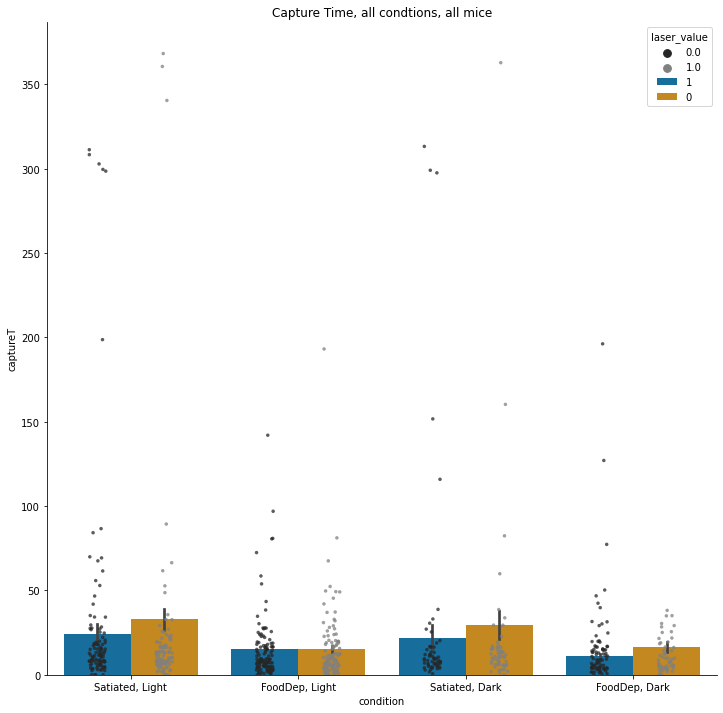

In [573]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

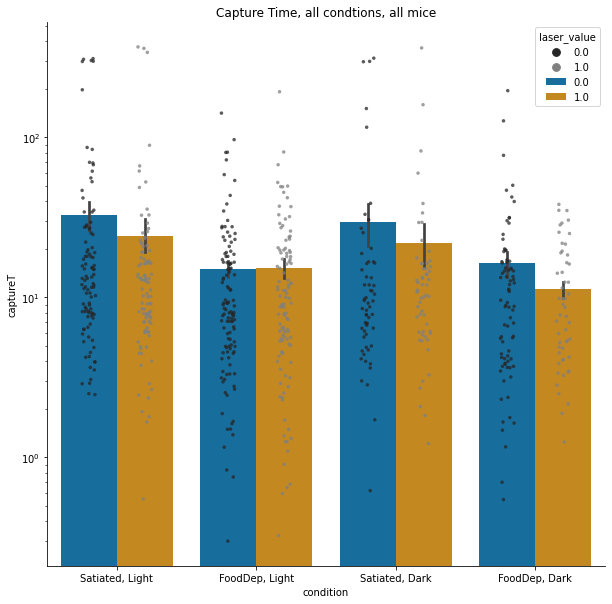

In [552]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,50)
sns.despine()

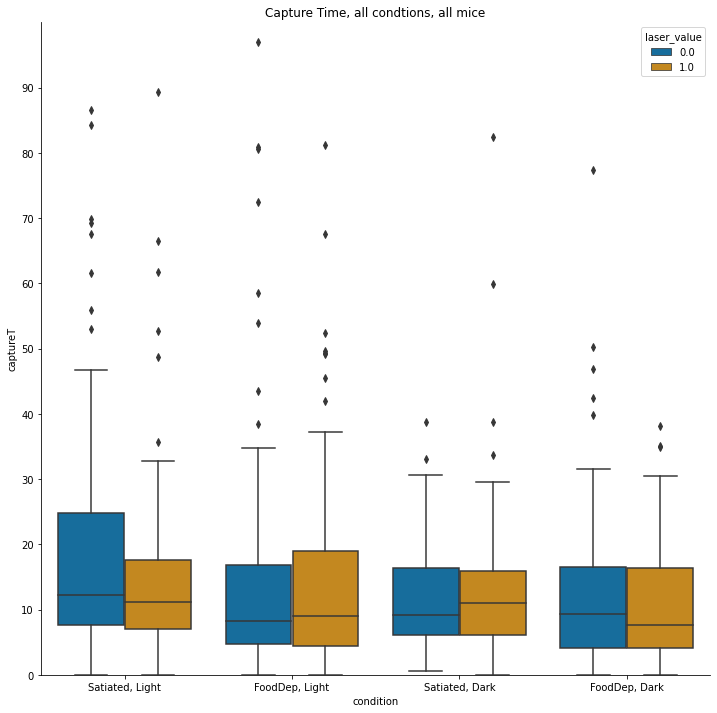

In [553]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,100)
plt.yticks(np.arange(0,100,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

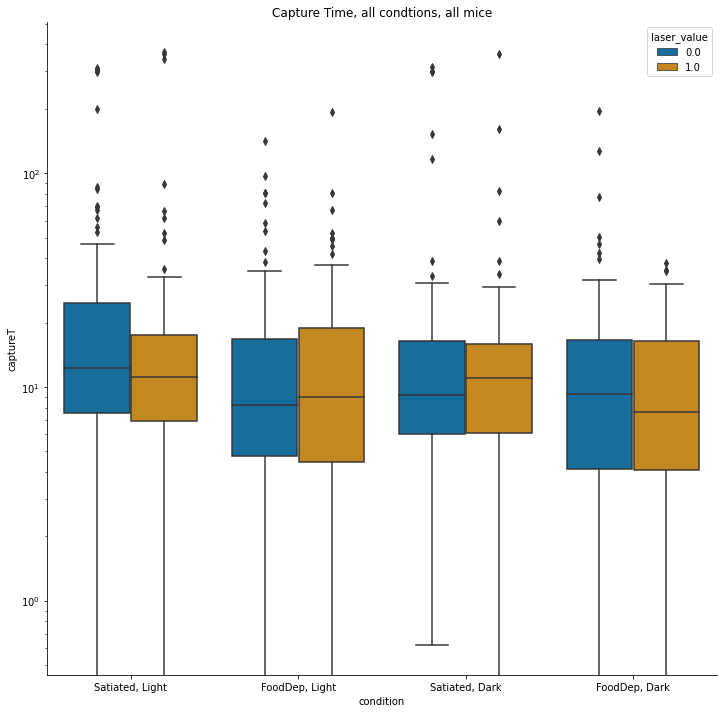

In [554]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

<a id= 'Capture-Times-120s' ></a>
#### Plot mean capture times for dataset that has capture times longer than 120s removed (or should be, don't entirely trust this dataframe/ h5 file right now, need to dig into how it was generated).
###### return to [Table of Contents](#Table-of-Contents)

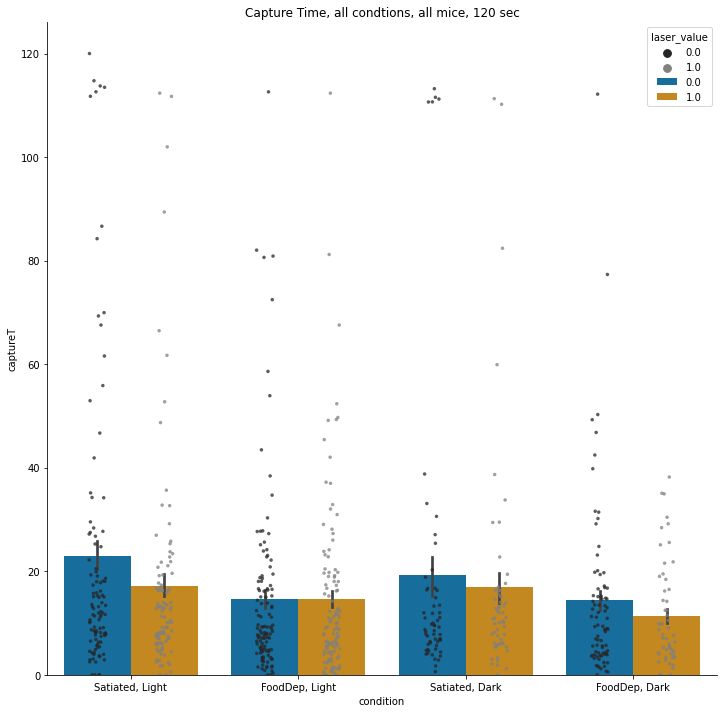

In [546]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df_120s, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df_120s, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice, 120 sec')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
sns.despine()

<a id= 'Approach-Latency-NoNan' ></a>
#### Plot mean time to approach for all mice, all data, all conditions
###### return to [Table of Contents](#Table-of-Contents)

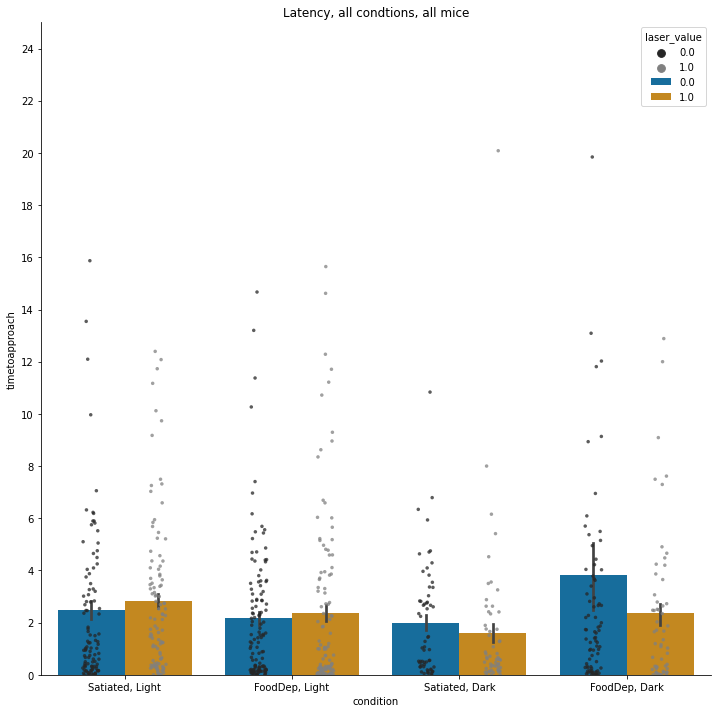

In [547]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='timetoapproach', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Latency, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

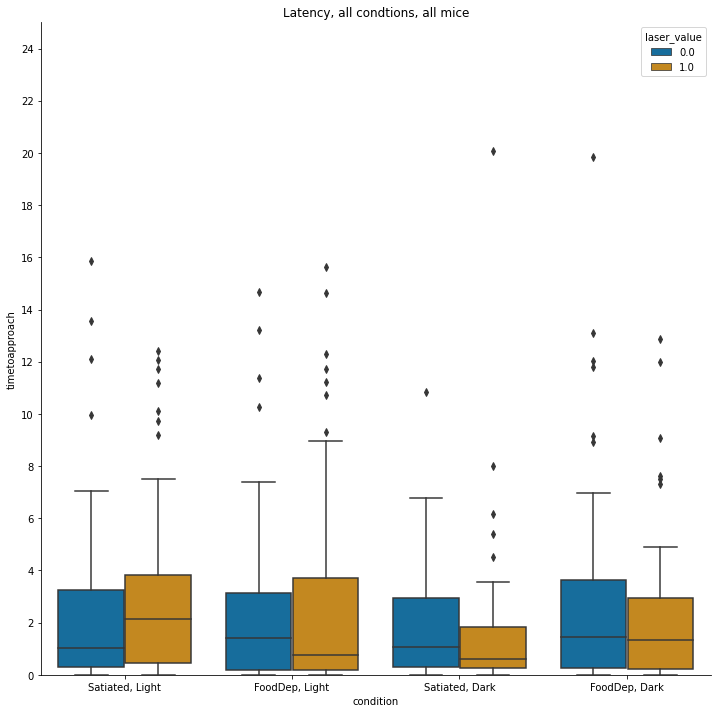

In [551]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='timetoapproach', hue='laser_value',  palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Latency, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

<a id= 'Approach-Latency-120s' ></a>
#### Mean time to approach for 120s dataset
###### return to [Table of Contents](#Table-of-Contents)

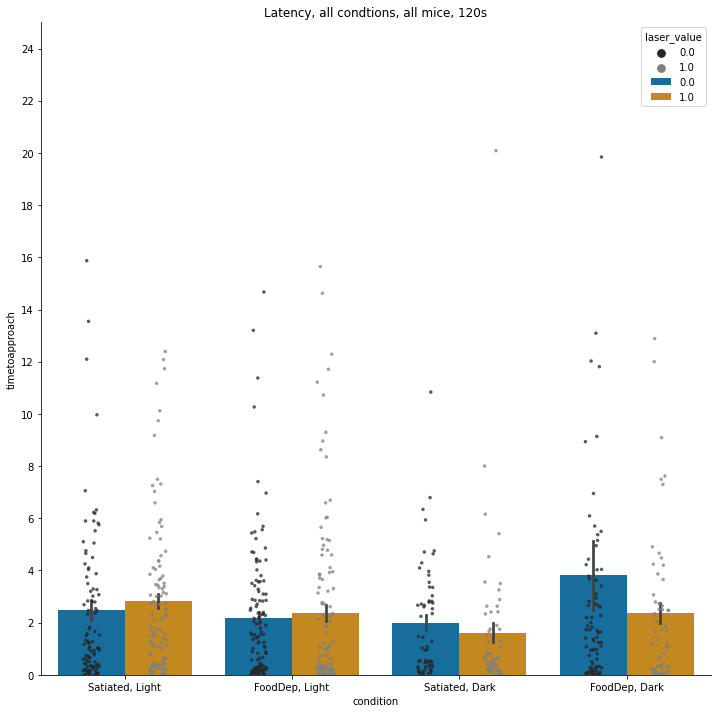

In [548]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df_120s, x='condition', y='timetoapproach', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetoapproach', hue='laser_value',dodge=True, data=df_120s, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Latency, all condtions, all mice, 120s')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.ylim(0,25)
plt.yticks(np.arange(0,25,2))
sns.despine()

<a id= 'Intercept-Latency-NoNan' ></a>
#### Mean latency to interception (time to first contact) for all data, all conditions all mice
###### return to [Table of Contents](#Table-of-Contents)

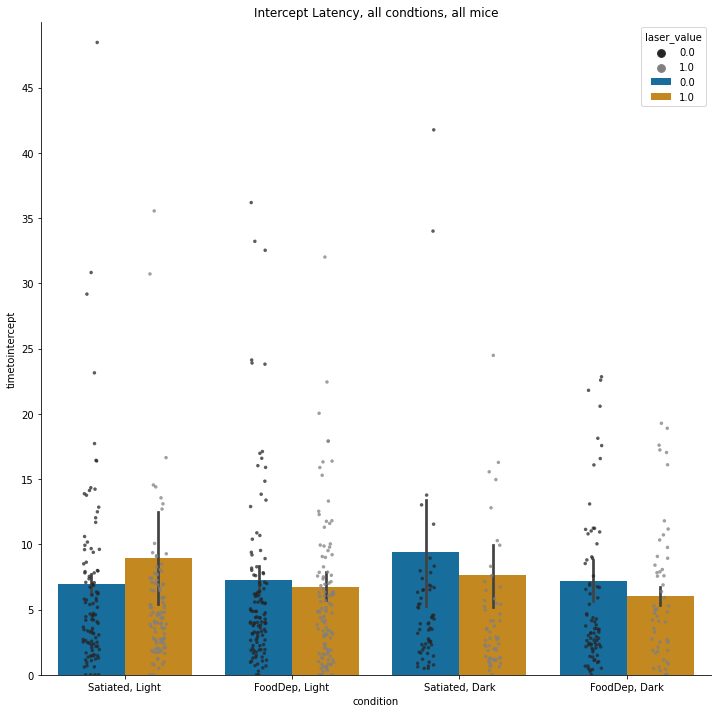

In [549]:
plt.figure(figsize=(12,12))
ax=sns.barplot(data=df, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind",hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Intercept Latency, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
sns.despine()

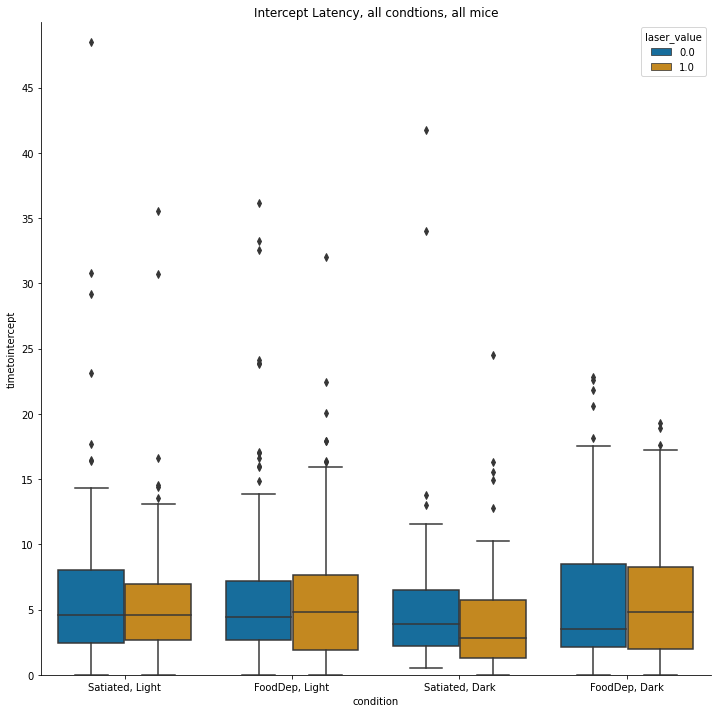

In [550]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(data=df, x='condition', y='timetointercept', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, alpha=0.75)
plt.title('Intercept Latency, all condtions, all mice')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
sns.despine()

#### Plot data for individual mice, first need to create a df for each of the mice to easily access the data

<a id= 'Mouse-0896' ></a>
#### mouse 0896
###### return to [Table of Contents](#Table-of-Contents)

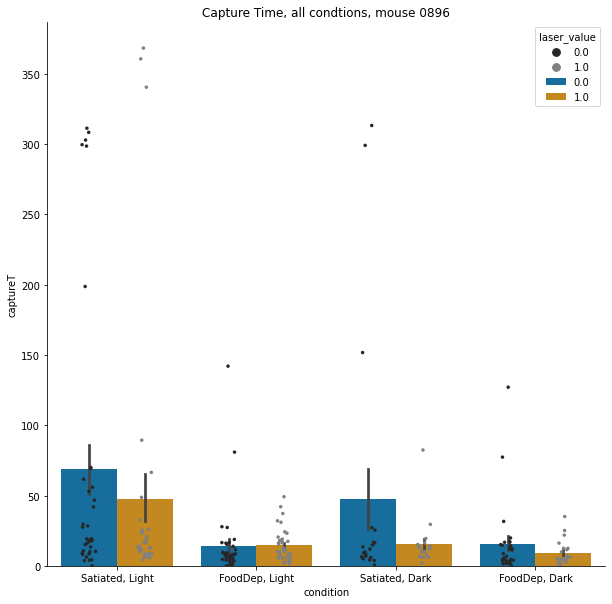

In [556]:
df['filename']=df['filename'].astype('str')
df0896=df[df['filename'].str.contains('0896')]
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind",hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5, hue_order=hue_order)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0896')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

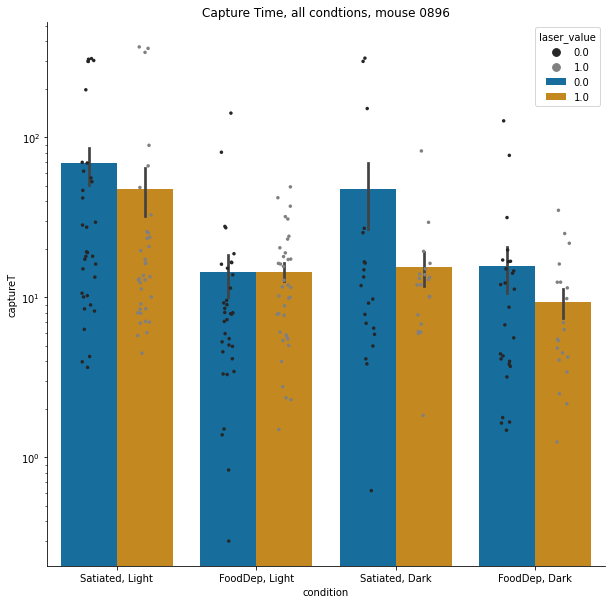

In [559]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0896, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5, hue_order=hue_order)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

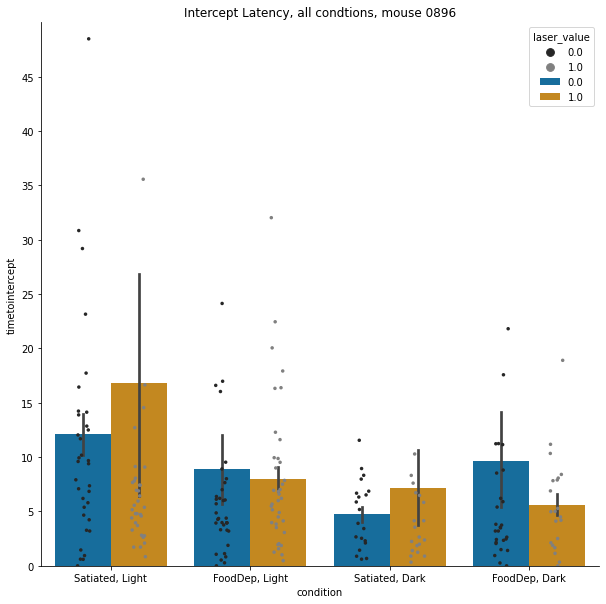

In [560]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0896, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5, hue_order=hue_order)
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
plt.title('Intercept Latency, all condtions, mouse 0896')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

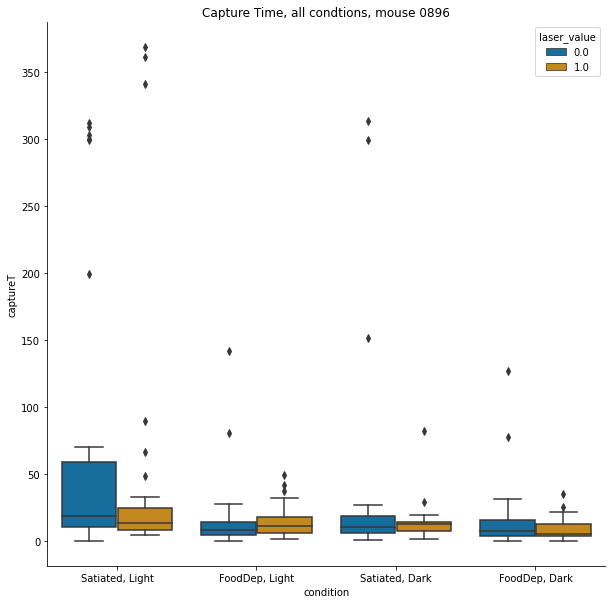

In [562]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(data=df0896, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0896')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

<a id= 'Mouse-0897' ></a>
#### mouse 0897
###### return to [Table of Contents](#Table-of-Contents)

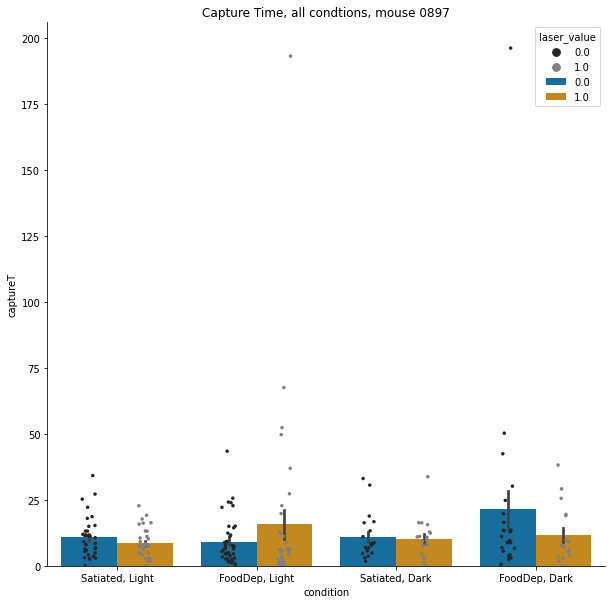

In [563]:
df0897=df[df['filename'].str.contains('0897')]
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5, hue_order=hue_order)
plt.title('Capture Time, all condtions, mouse 0897')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# # plt.ylim(0,50)
sns.despine()

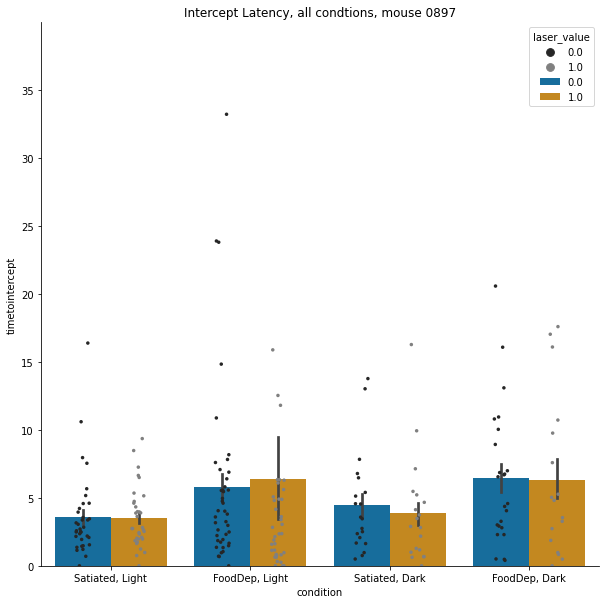

In [564]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0897, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5, hue_order=hue_order)
plt.ylim(0,40)
plt.yticks(np.arange(0,40,5))
plt.title('Intercept Latency, all condtions, mouse 0897')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

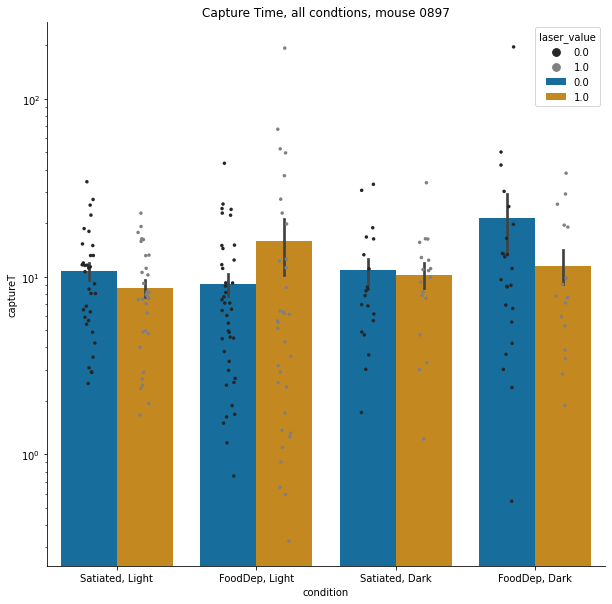

In [565]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0897, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0897, color='gray', size=3.5, hue_order=hue_order)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

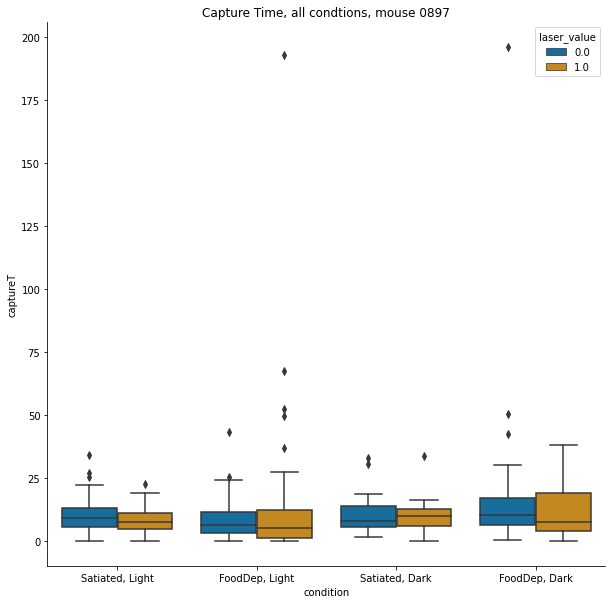

In [566]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(data=df0897, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0897')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

<a id= 'Mouse-0898' ></a>
#### mouse 0898
###### return to [Table of Contents](#Table-of-Contents)

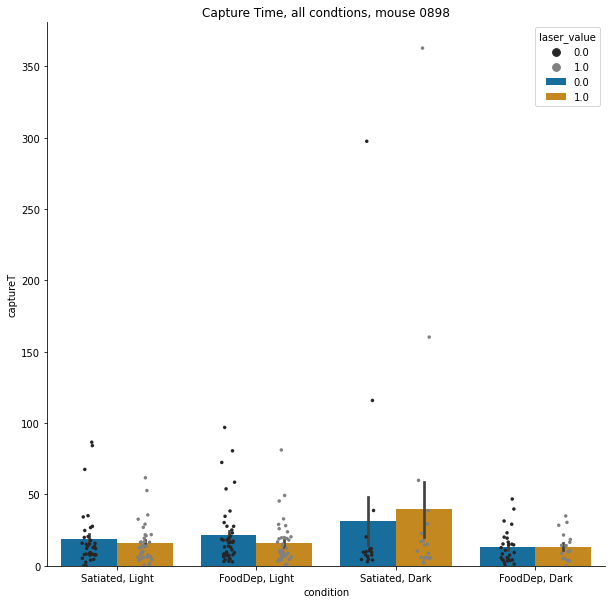

In [567]:
df0898=df[df['filename'].str.contains('0898')]
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5, hue_order=hue_order)
# # plt.ylim(0,50)
plt.title('Capture Time, all condtions, mouse 0898')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

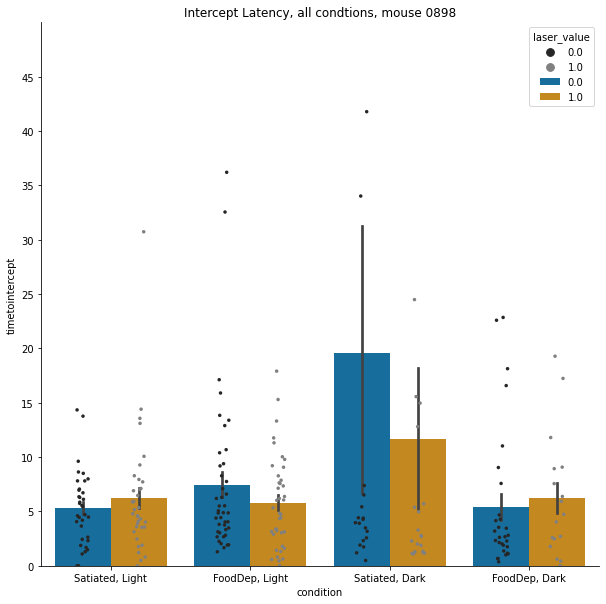

In [568]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0898, x='condition', y='timetointercept', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='timetointercept', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5, hue_order=hue_order)
plt.ylim(0,50)
plt.yticks(np.arange(0,50,5))
plt.title('Intercept Latency, all condtions, mouse 0898')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

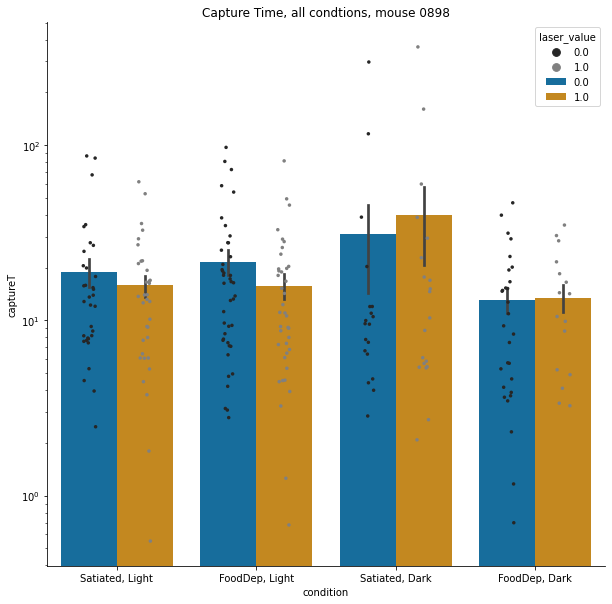

In [570]:
plt.figure(figsize=(10,10))
ax=sns.barplot(data=df0898, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0898, color='gray', size=3.5, hue_order=hue_order)
ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

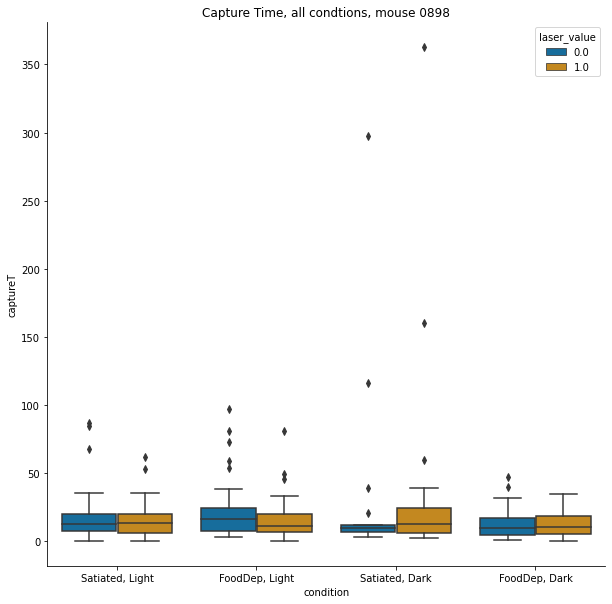

In [571]:
plt.figure(figsize=(10,10))
ax=sns.boxplot(data=df0898, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df0896, color='gray', size=3.5)
# ax.set_yscale('log')
plt.title('Capture Time, all condtions, mouse 0898')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

<a id= 'Session-ID' ></a>
#### Plotting various measures across the course of sessions within condition. This doesn't really tell us anything informative.
###### return to [Table of Contents](#Table-of-Contents)

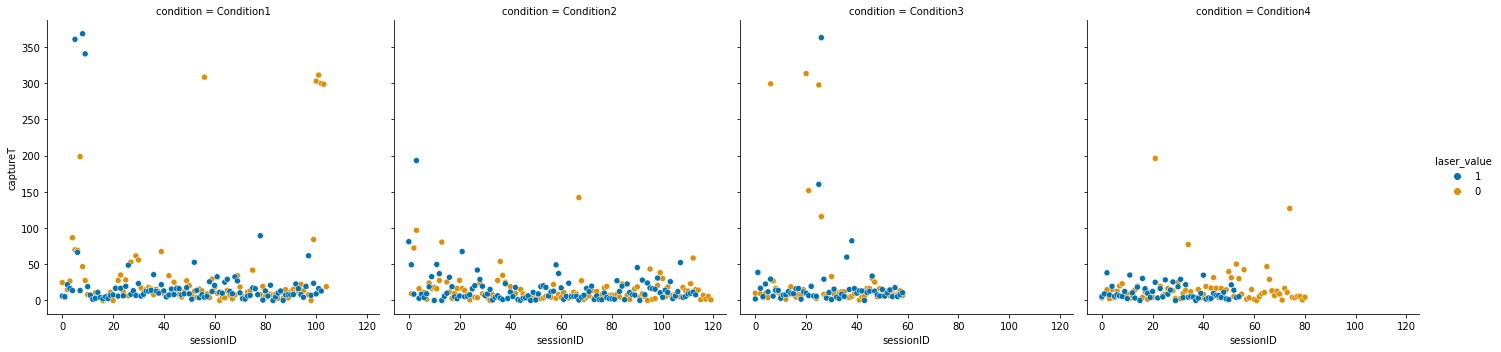

In [584]:
sns.relplot(x='sessionID', y='captureT', col='condition', hue='laser_value', data=copydf,palette="colorblind", hue_order=hue_order)
# plt.xlim(0,20)
# plt.ylim(0,100)

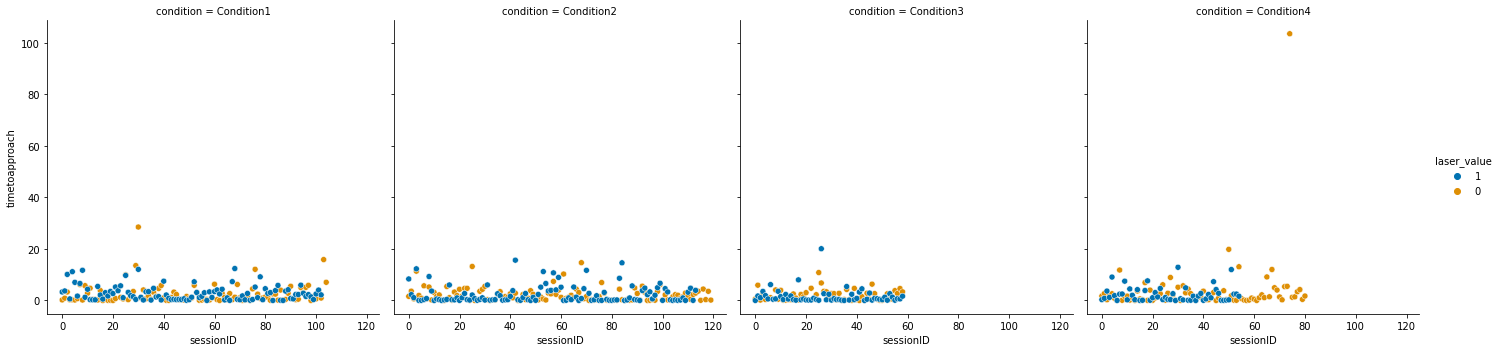

In [585]:
sns.relplot(x='sessionID', y='timetoapproach', col='condition', hue='laser_value', data=copydf,palette="colorblind", hue_order=hue_order)
# plt.ylim(0,25)
# plt.xlim(0,20)

(0.0, 50.0)

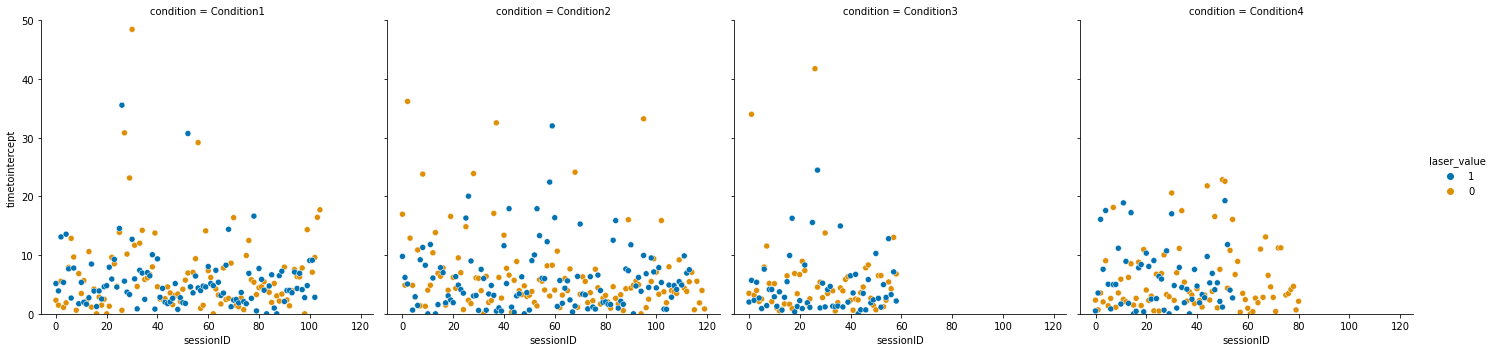

In [586]:
sns.relplot(x='sessionID', y='timetointercept', col='condition', hue='laser_value', data=copydf,palette="colorblind", hue_order=hue_order)
plt.ylim(0,50)

(0.0, 100.0)

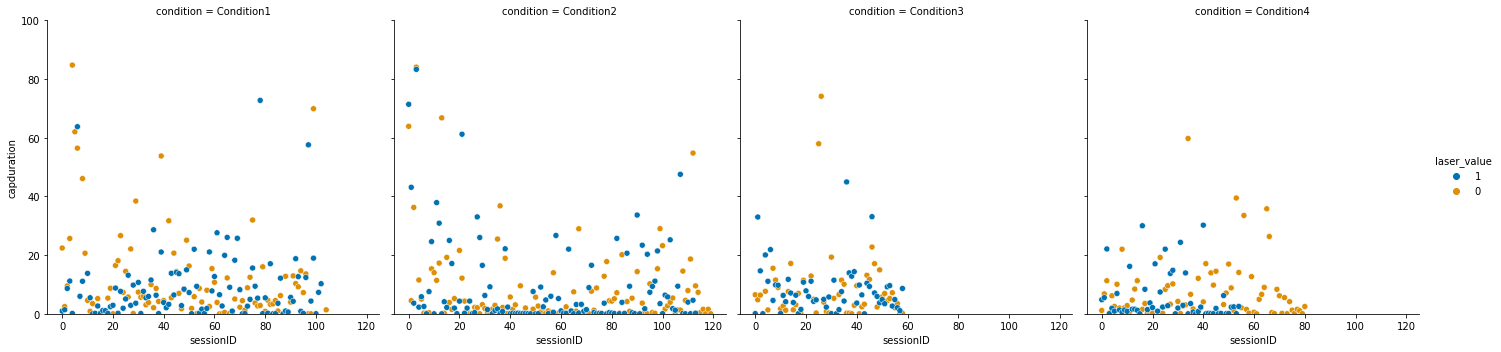

In [587]:
sns.relplot(x='sessionID', y='capduration', col='condition', hue='laser_value', data=copydf,palette="colorblind", hue_order=hue_order)
plt.ylim(0,100)
# plt.xlim(0,40)

<a id= 'Speed' ></a>
#### Plot average mouse speed across condtions and trials. Need to separate out the speed into pursuit/ approach speed to get a better idea of if the laser has any effect.
###### return to [Table of Contents](#Table-of-Contents)

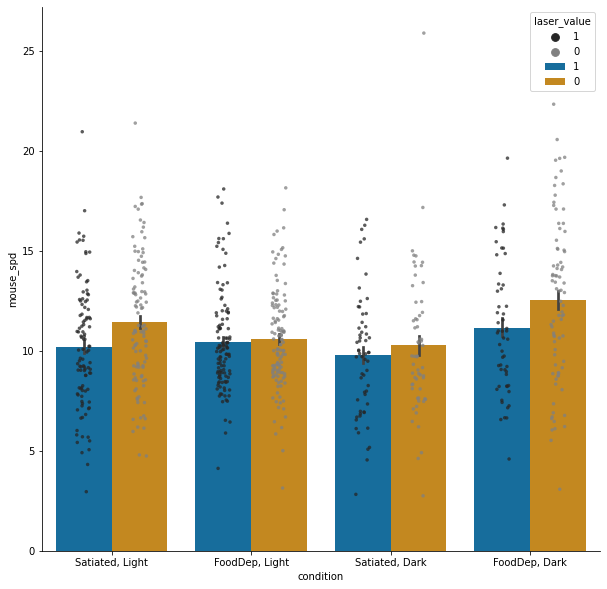

In [596]:
plt.figure(figsize=(10,10))
sns.barplot(data=meanspeed,x='condition', y='mouse_spd', hue='laser_value', ci=68,palette="colorblind", hue_order=hue_order)
sns.stripplot(x='condition', y='mouse_spd', hue='laser_value',dodge=True, data=meanspeed, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

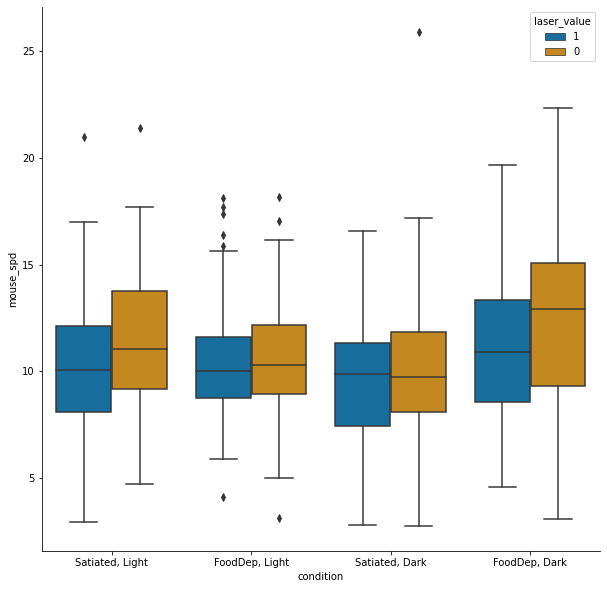

In [612]:
plt.figure(figsize=(10,10))
sns.boxplot(data=meanspeed,x='condition', y='mouse_spd', hue='laser_value',palette="colorblind", hue_order=hue_order)
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()

<a id= 'Capture-Durations-NoNan' ></a>
#### Comparison plots between capture time and capture duration for all data, no times thrown out.
###### return to [Table of Contents](#Table-of-Contents)

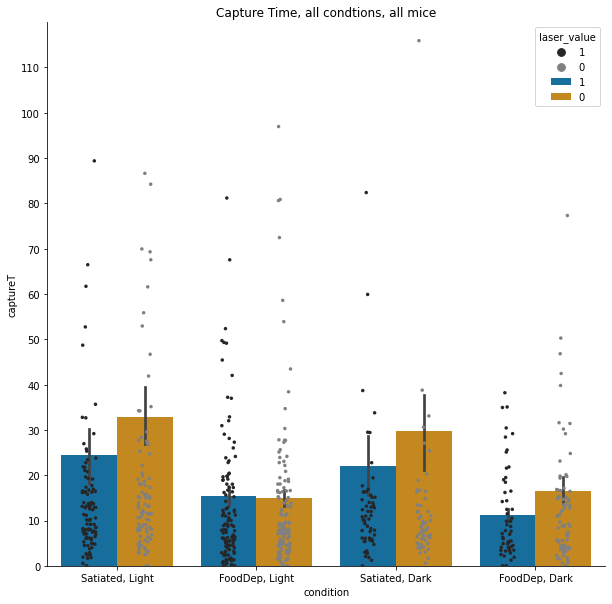

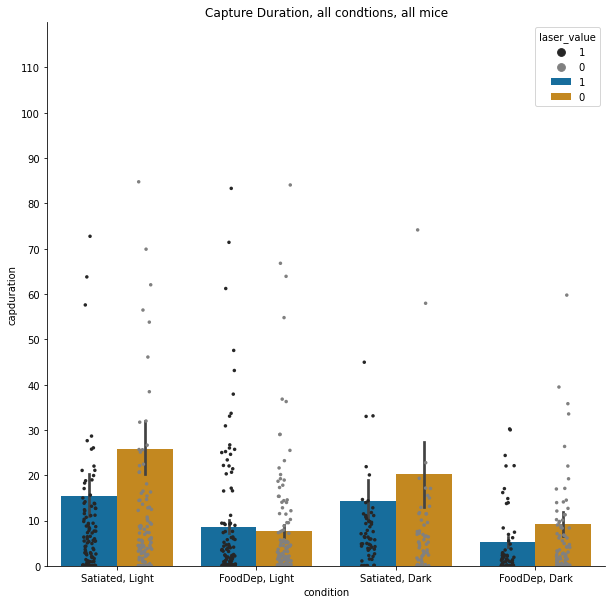

In [579]:
fig1= plt.figure(figsize=(10,10))
sns.barplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order, ci=68)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])

sns.despine()
                  
fig2=plt.figure(figsize=(10,10))
sns.barplot(data=df, x='condition', y='capduration', hue='laser_value', palette="colorblind", hue_order=hue_order, ci=68)
sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=df, color='gray', size=3.5, hue_order=hue_order)
plt.title('Capture Duration, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])

sns.despine()

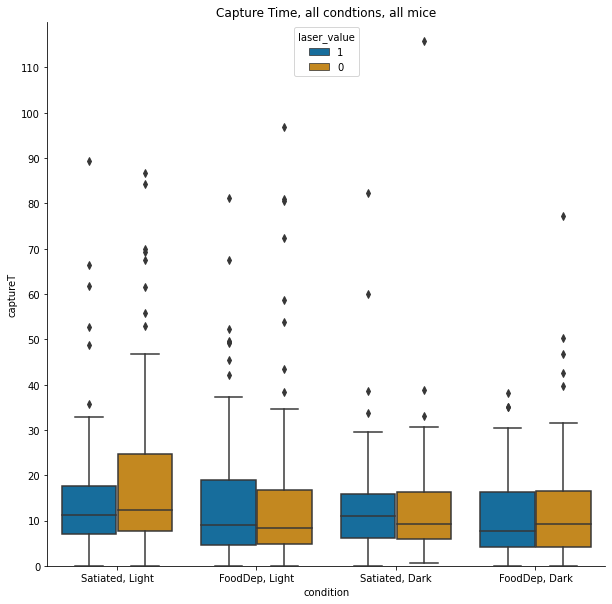

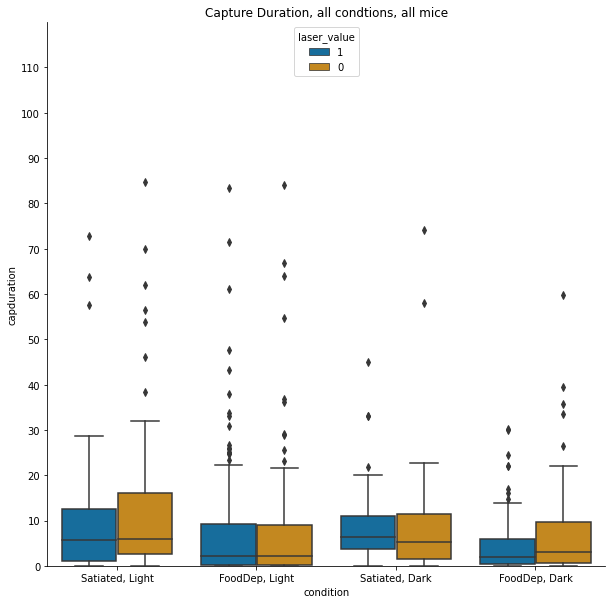

In [578]:
fig1= plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])

sns.despine()
fig2=plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='condition', y='capduration', hue='laser_value', palette="colorblind", hue_order=hue_order)
plt.title('Capture Duration, all condtions, all mice')
plt.ylim(0,120)
plt.yticks(np.arange(0,120,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

<a id= 'Capture-Times-300s' ></a>
<a id= 'Capture-Durations-300s' ></a>
#### Comparison plots between capture time and capture duration for all data, 300s.
###### return to [Table of Contents](#Table-of-Contents)

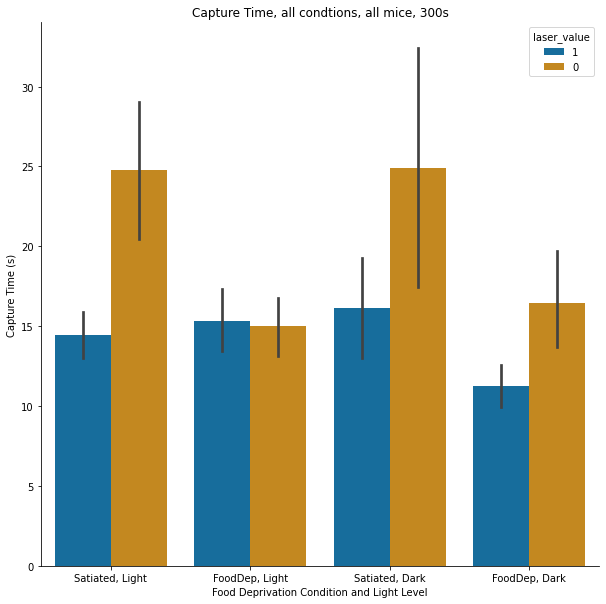

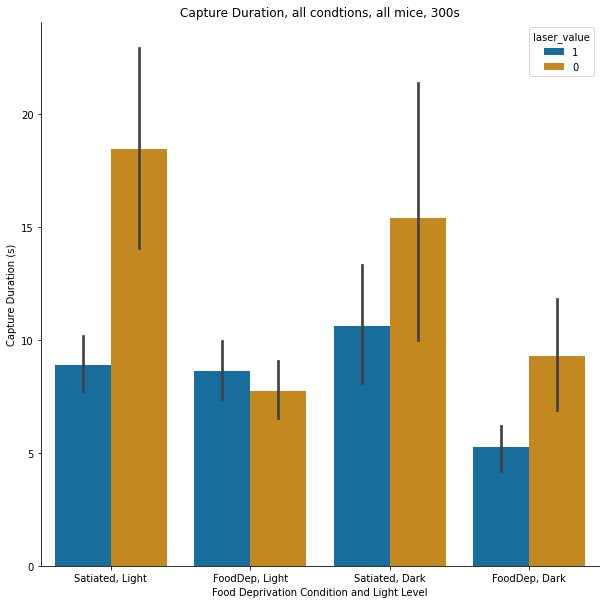

In [724]:
fig1= plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=nandf, color='gray', size=3.5, alpha=0.85, hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice, 300s')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.xlabel('Food Deprivation Condition and Light Level')
plt.ylabel('Capture Time (s)')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_bar_300s_nodot.pdf')

fig2=plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf, x='condition', y='capduration', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=nandf, color='gray', size=3.5, alpha=0.85, hue_order=hue_order)
plt.title('Capture Duration, all condtions, all mice, 300s')
# plt.ylim(0,100)
# plt.yticks(np.arange(0,100,10))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.xlabel('Food Deprivation Condition and Light Level')
plt.ylabel('Capture Duration (s)')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_bar_300s_nodot.pdf')

<a id= 'Capture-Times-120s' ></a>
#### Comparison plots between capture time and capture duration for all data, 120s.
###### return to [Table of Contents](#Table-of-Contents)

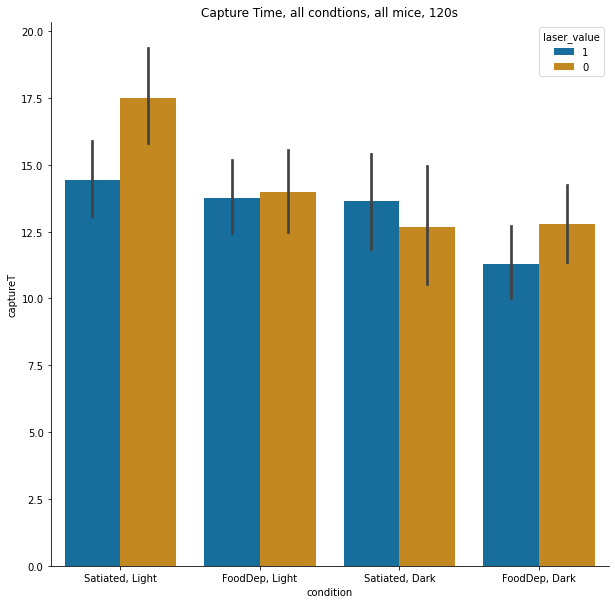

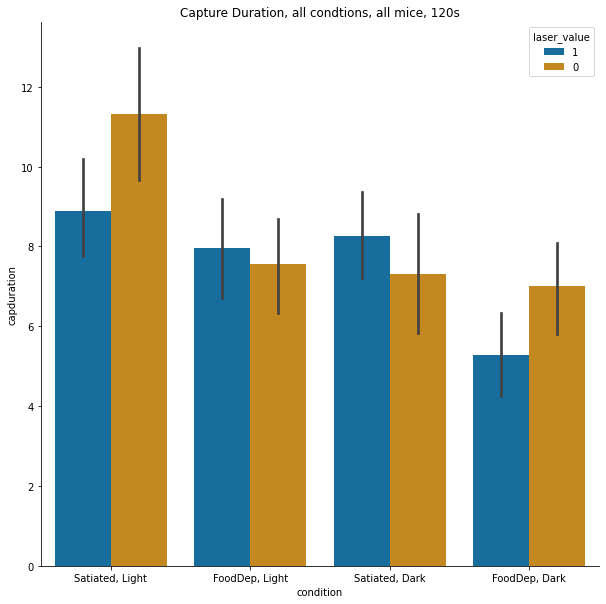

In [619]:
fig1= plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf_120, x='condition', y='captureT', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=nandf_120, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Capture Time, all condtions, all mice, 120s')
# plt.ylim(0,40)
# plt.yticks(np.arange(0,40,5))
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
sns.despine()
fig2=plt.figure(figsize=(10,10))
ax=sns.barplot(data=nandf_120, x='condition', y='capduration', hue='laser_value', ci=68, palette="colorblind", hue_order=hue_order)
ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=nandf_120, color='gray', size=3.5, alpha=0.75, hue_order=hue_order)
plt.title('Capture Duration, all condtions, all mice, 120s')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,40)
# plt.yticks(np.arange(0,40,5))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

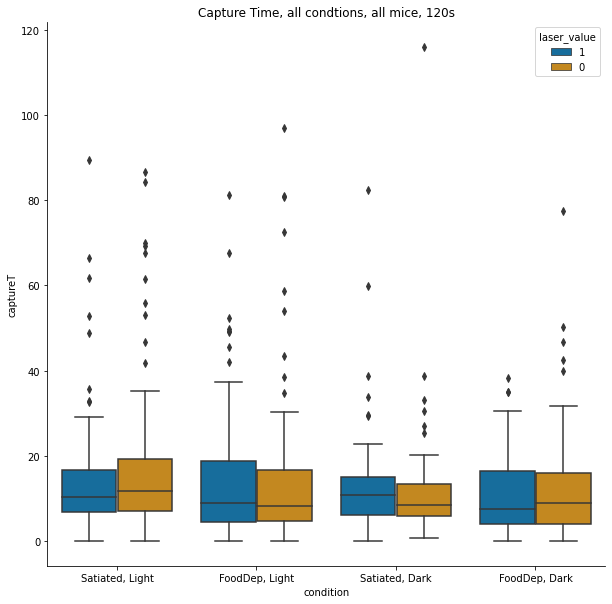

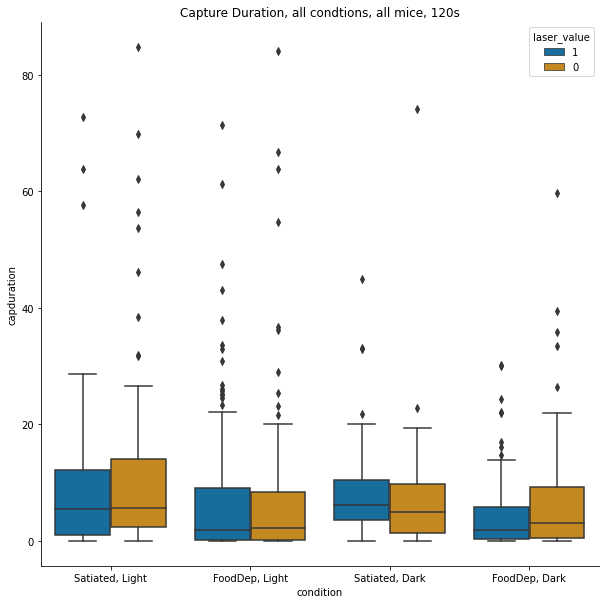

In [620]:
fig1= plt.figure(figsize=(10,10))
ax=sns.boxplot(data=nandf_120, x='condition', y='captureT', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=nandf120, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Time, all condtions, all mice, 120s')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,120)
# plt.yticks(np.arange(0,120,10))
sns.despine()
fig2=plt.figure(figsize=(10,10))
ax=sns.boxplot(data=nandf_120, x='condition', y='capduration', hue='laser_value', palette="colorblind", hue_order=hue_order)
# ax= sns.stripplot(x='condition', y='capduration', hue='laser_value',dodge=True, data=nandf120, color='gray', size=3.5, alpha=0.75)
plt.title('Capture Duration, all condtions, all mice, 120s')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
# plt.ylim(0,120)
# plt.yticks(np.arange(0,120,10))
# ax.set_yscale('log')
# ax= sns.stripplot(x='condition', y='captureT', hue='laser_value',dodge=True, data=df, color='gray', size=3.5)
sns.despine()

<a id= 'Distributions' ></a>
# Doing some stuff to try to plot distributions of capture time and duration instead of just means and medians to see if something is different between the laser conditions.
###### return to [Table of Contents](#Table-of-Contents)

<a id= 'Distributions-300s' ></a>
#### Emprircal cumulative distribtion function plots for capture times, times over 300s removed.
###### return to [Table of Contents](#Table-of-Contents)

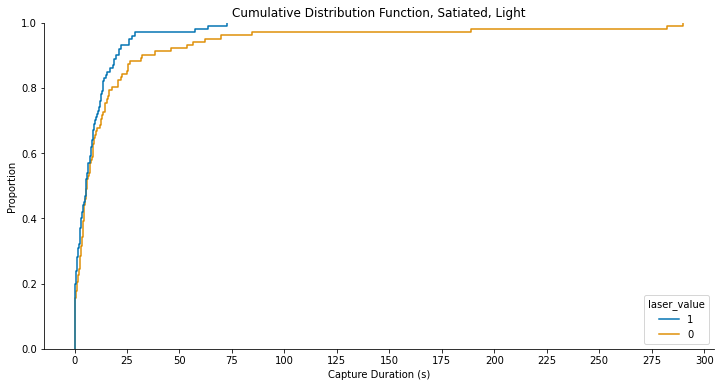

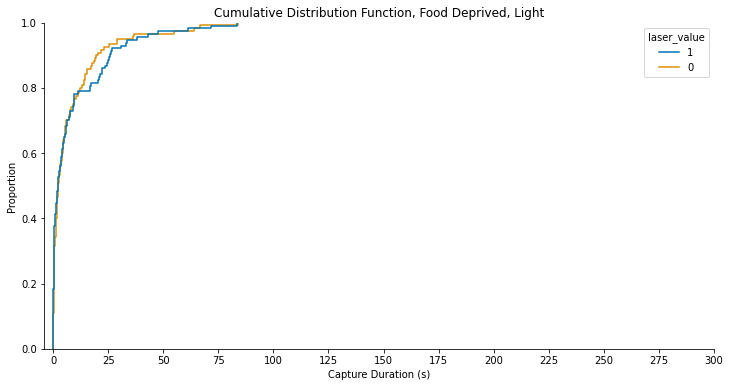

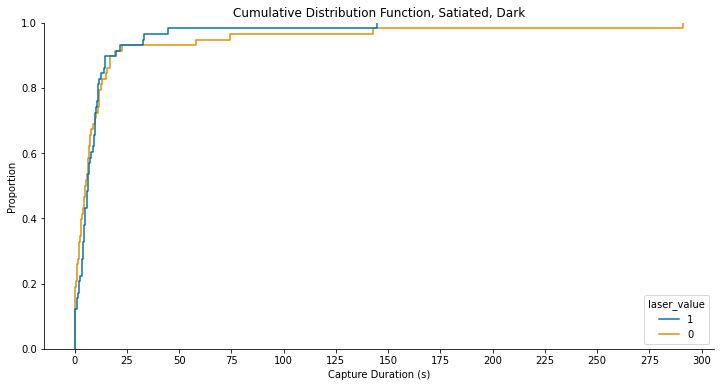

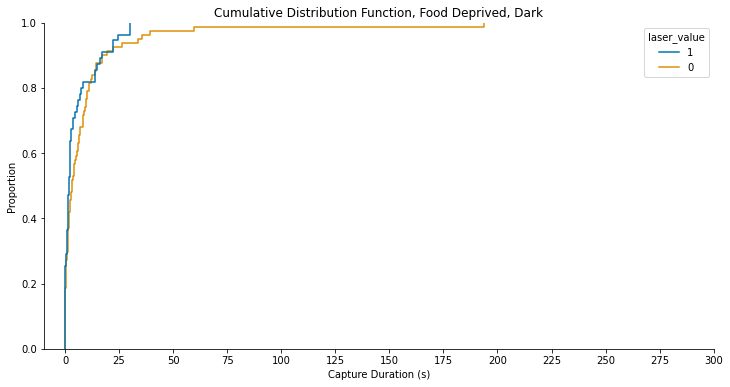

In [719]:
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond1, x='capduration', hue='laser_value',hue_order=hue_order, palette="colorblind")
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Light')
plt.xticks(np.arange(0, 325,25))
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_satiatedL.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond2, x='capduration', hue='laser_value',hue_order=hue_order,palette="colorblind")
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_fooddepL.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond3, x='capduration', hue='laser_value',hue_order=hue_order,palette="colorblind")
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark')
plt.xticks(np.arange(0, 325,25))
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_satiatedD.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond4, x='capduration', hue='laser_value',hue_order=hue_order,palette="colorblind")
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_fooddepD.pdf')

#### Emprircal cumulative distribtion function plots for capture durations, times over 300s removed.
###### return to [Table of Contents](#Table-of-Contents)

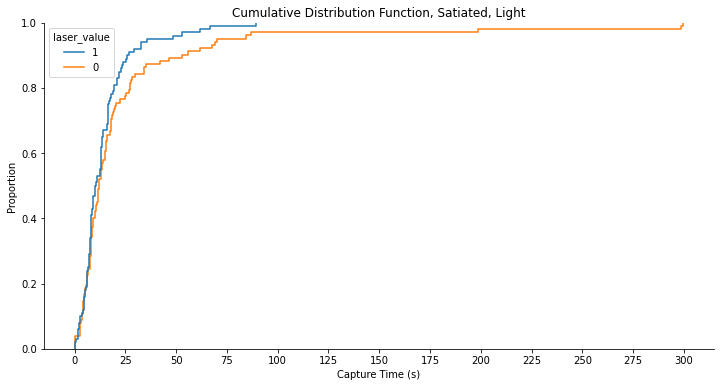

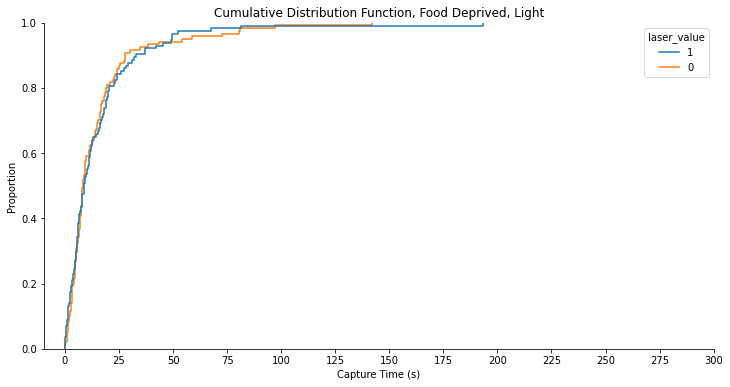

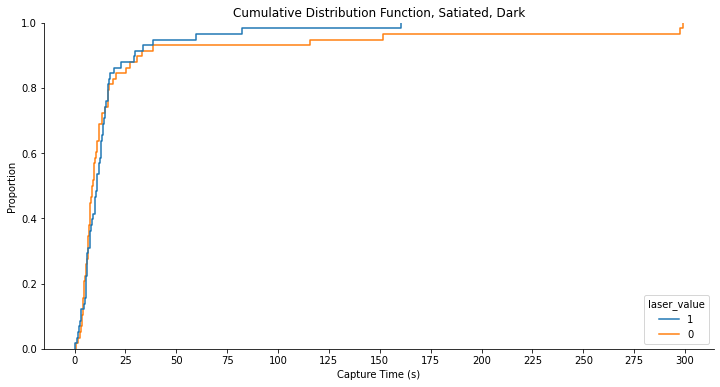

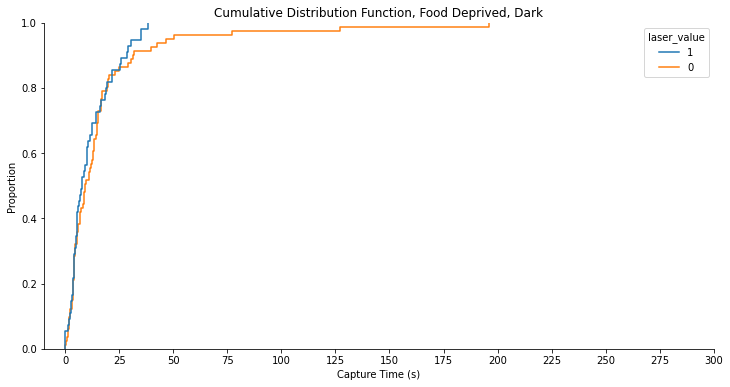

In [539]:
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond1, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Light')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_satiatedL.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond2, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_fooddepL.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond3, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_satiatedD.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond4, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark')
plt.xticks(np.arange(0, 325,25))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_fooddepD.pdf')

#### Histograms (actual counts) overlayed with kernal desnsity estimation plots for capture times, times over 300s removed.
###### return to [Table of Contents](#Table-of-Contents)

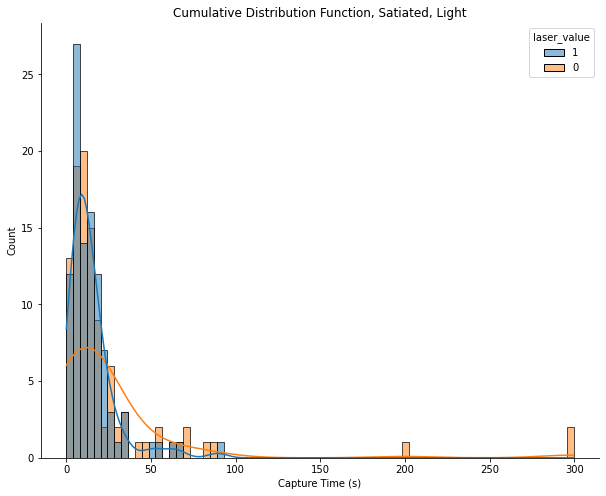

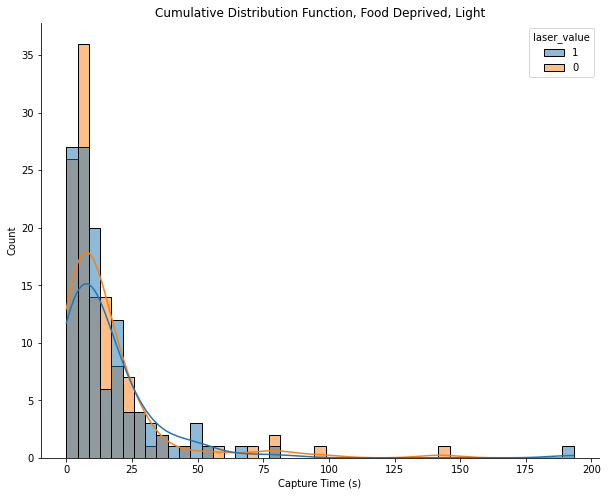

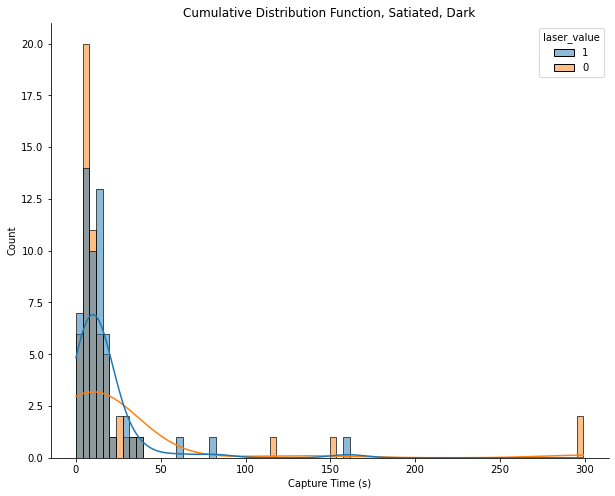

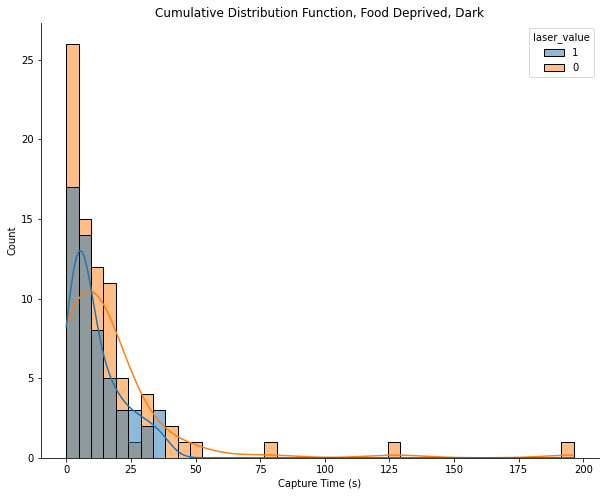

In [519]:
hue_order=[1,0]
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=cond1, x='captureT', hue='laser_value', kde=True, hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Light')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedL.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=cond2, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepL.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=cond3, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedD.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=cond4, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark')
sns.despine()
plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepD.pdf')

#### Histograms (actual counts) overlayed with kernal desnsity estimation plots for capture durations, times over 300s removed.
###### return to [Table of Contents](#Table-of-Contents)

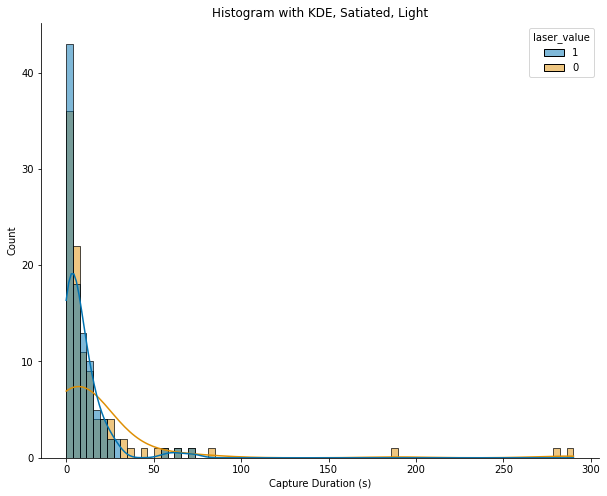

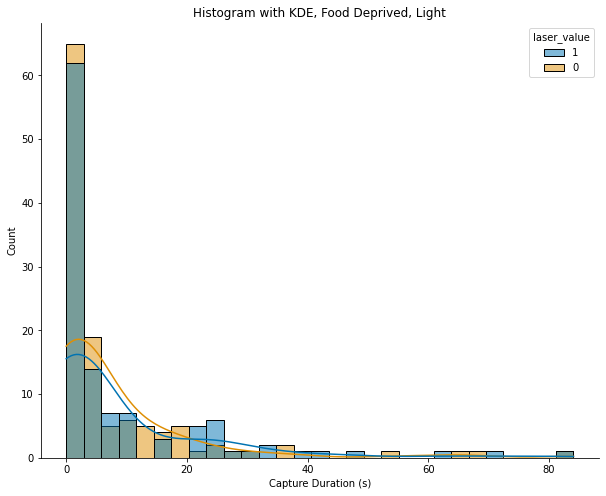

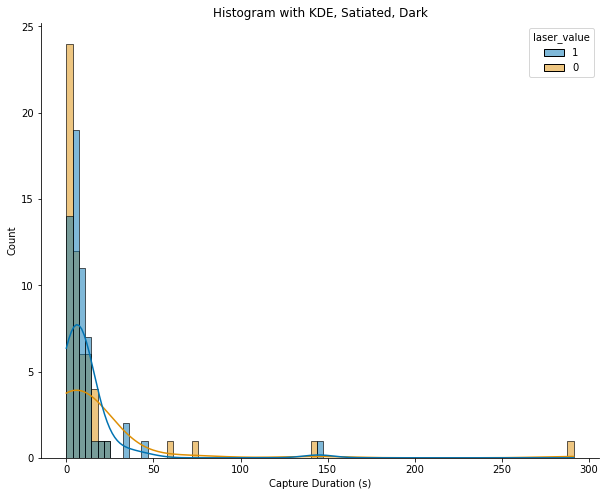

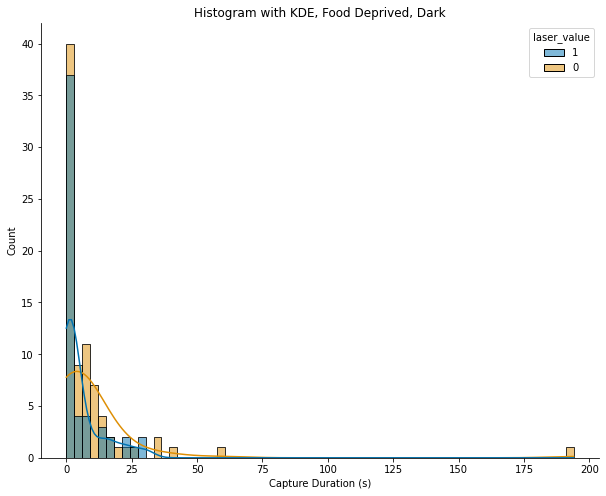

In [718]:
hue_order=[1,0]
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=cond1, x='capduration', hue='laser_value', kde=True,hue_order=hue_order,palette="colorblind")
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Light')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedL.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=cond2, x='capduration', hue='laser_value', kde=True,hue_order=hue_order,palette="colorblind")
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Light')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepL.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=cond3, x='capduration', hue='laser_value', kde=True,hue_order=hue_order,palette="colorblind")
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Dark')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedD.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=cond4, x='capduration', hue='laser_value', kde=True,hue_order=hue_order,palette="colorblind")
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Dark')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepD.pdf')

<a id= 'Distributions-120s' ></a>
#### Histograms (actual counts) overlayed with kernal desnsity estimation plots for capture times, times over 120s removed. First set of plots uses the df_120s generated as a separate h5 file. Another set of plots for 120s cutoff also created using an alternative method of replacing longer capture times with NaN based on basic testing.
###### return to [Table of Contents](#Table-of-Contents)

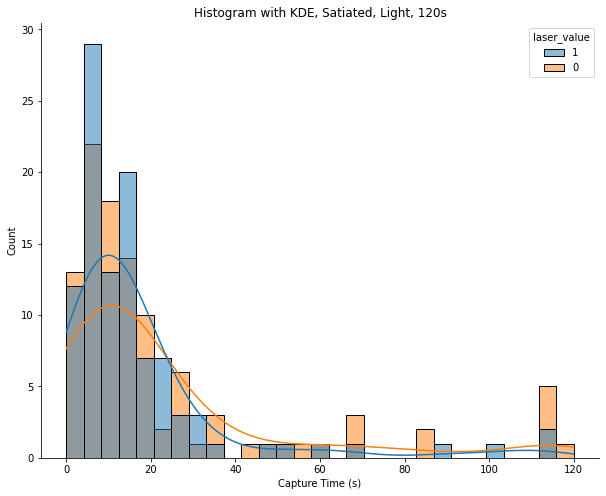

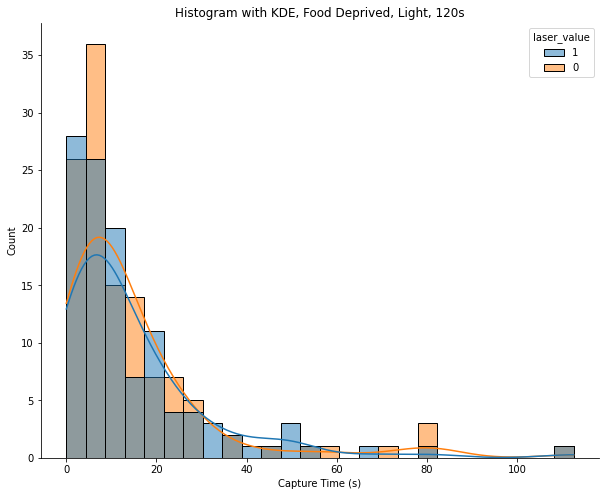

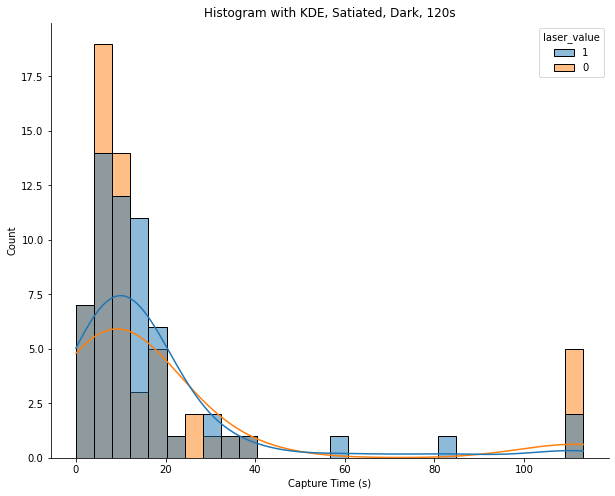

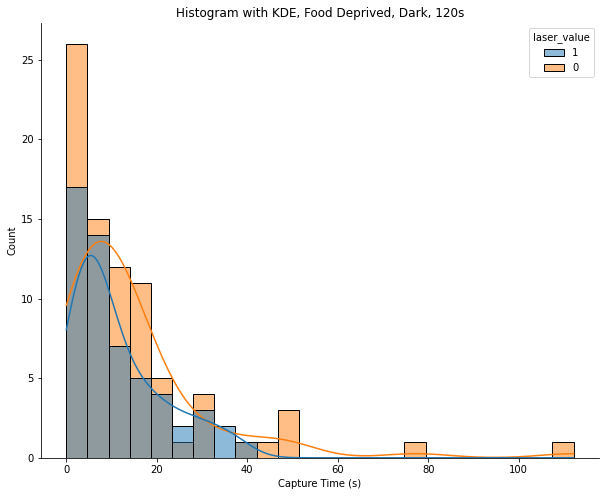

In [521]:
hue_order=[1,0]
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=cond1_120, x='captureT', hue='laser_value', kde=True, hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Satiated, Light, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedL120.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=cond2_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Food Deprived, Light, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepL120.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=cond3_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Satiated, Dark, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedD120.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=cond4_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Food Deprived, Dark, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepD120.pdf')

#### Histograms (actual counts) overlayed with kernal desnsity estimation plots for capture durations, times over 120s removed. First set of plots uses the df_120s generated as a separate h5 file. Another set of plots for 120s cutoff also created using an alternative method of replacing longer capture times with NaN based on basic testing.
###### return to [Table of Contents](#Table-of-Contents)

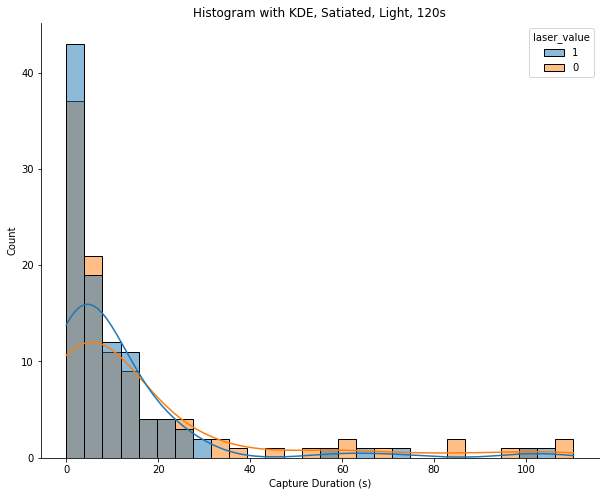

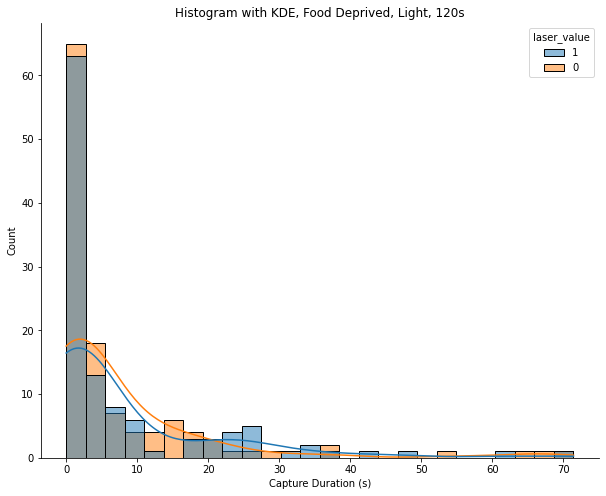

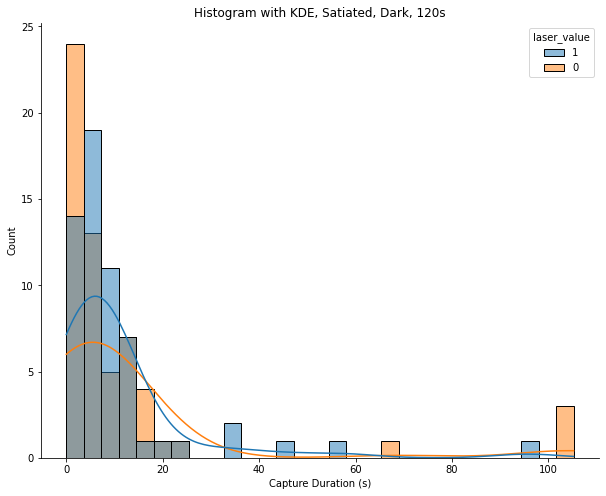

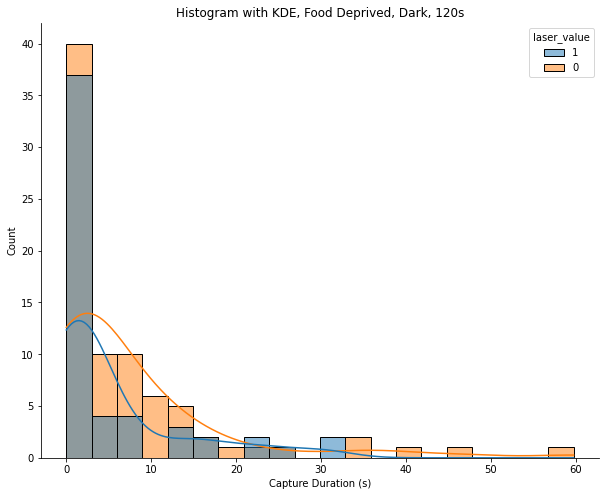

In [522]:
hue_order=[1,0]
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=cond1_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Light, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedL120.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=cond2_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Light, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepL120.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=cond3_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Dark, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedD120.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=cond4_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Dark, 120s')
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepD120.pdf')

#### Empirircal cumulative distribution function plots for capture times, times over 120s removed. First set of plots uses the df_120s generated as a separate h5 file. Another set of plots for 120s cutoff also created using an alternative method of replacing longer capture times with NaN based on basic testing.
###### return to [Table of Contents](#Table-of-Contents)

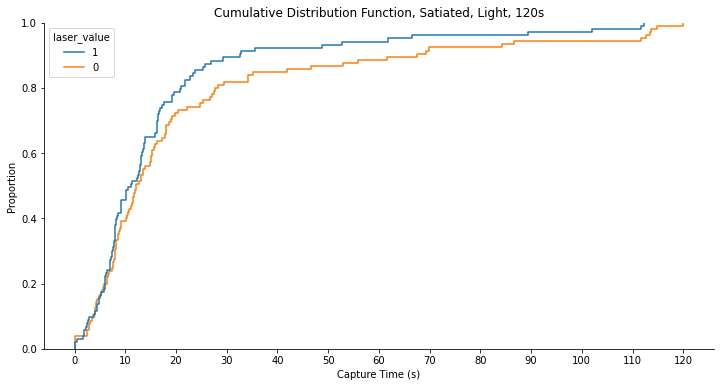

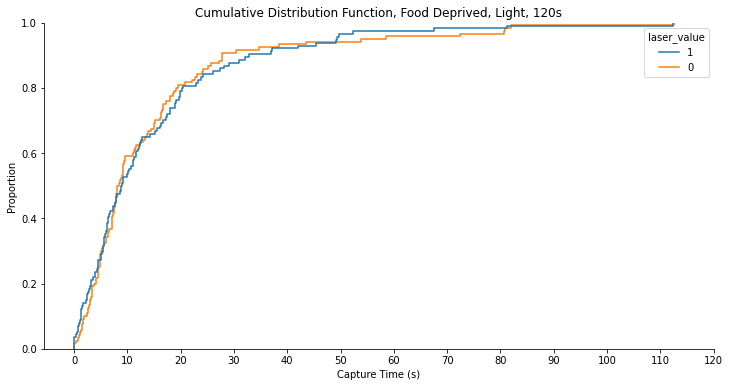

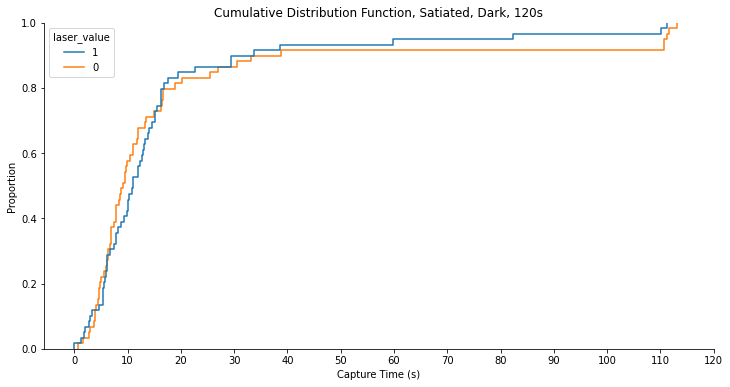

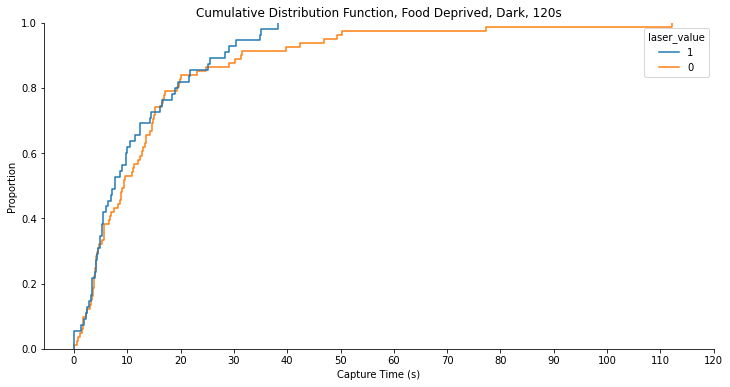

In [666]:
hue_order=[1,0]
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond1_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Light, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capT_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond2_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capT_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond3_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capT_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond4_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capT_fooddepD_120.pdf')


#### Empirircal cumulative distribution function plots for capture duration, times over 120s removed. First set of plots uses the df_120s generated as a separate h5 file. Another set of plots for 120s cutoff also created using an alternative method of replacing longer capture times with NaN based on basic testing.
###### return to [Table of Contents](#Table-of-Contents)

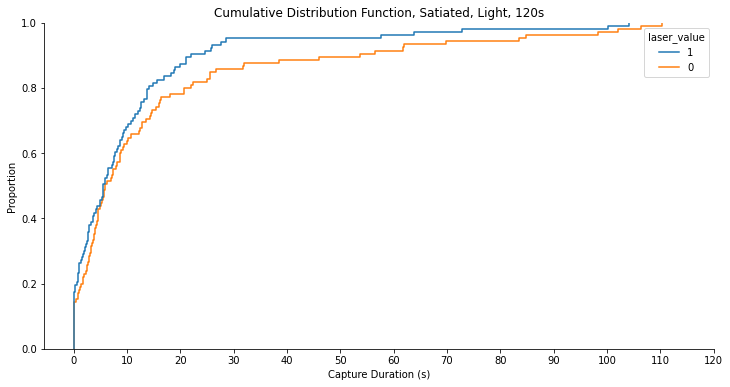

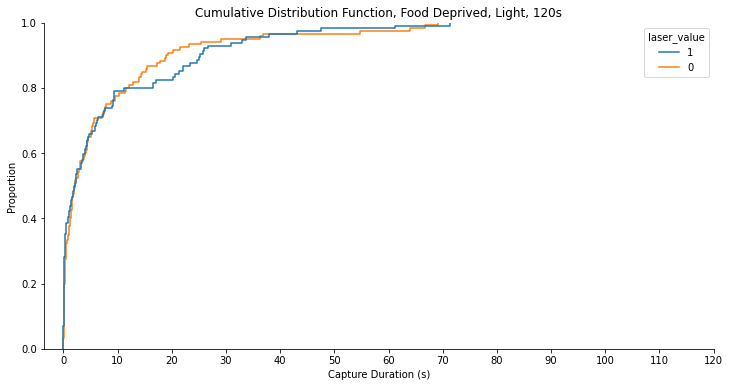

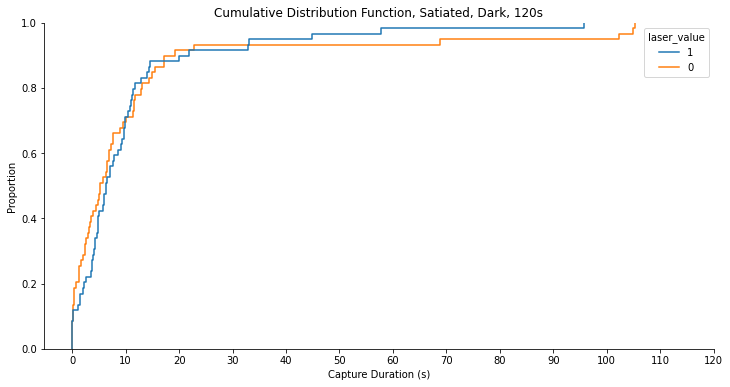

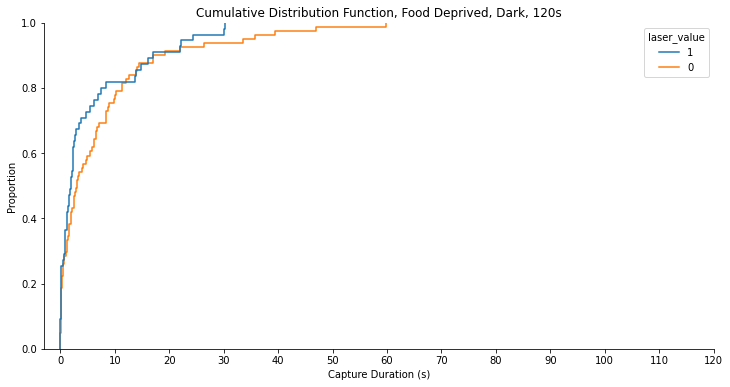

In [667]:
hue_order=hue_order
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond1_120, x='capduration', hue='laser_value', hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Light, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capduration_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond2_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capduration_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond3_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capduration_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=cond4_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0,125,10))
sns.despine()
# plt.savefig('capduration_fooddepD_120.pdf')

#### ECDF and histogram-KDE plots for capture time and duration, times over 120s removed. These plots used the df with NaNs replacing times longer than 120s that was done in line in this notebook, shows counts for NaNs unlike df_120s.
###### return to [Table of Contents](#Table-of-Contents)

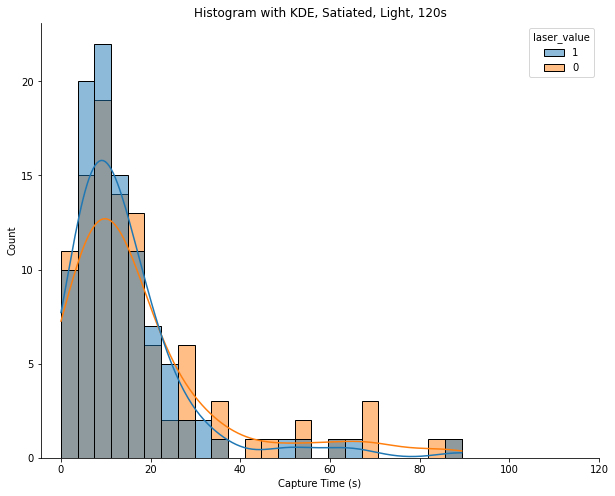

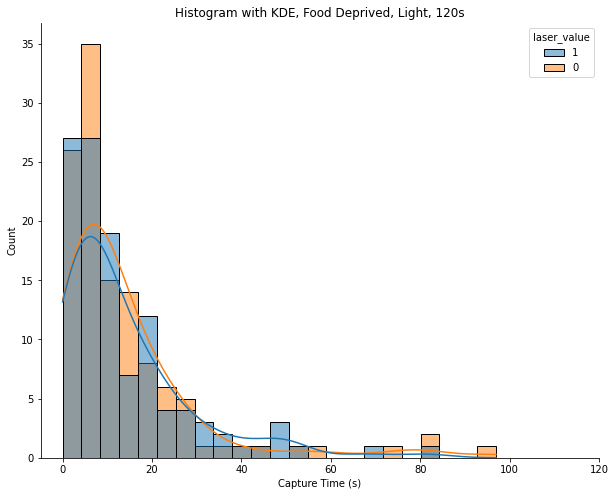

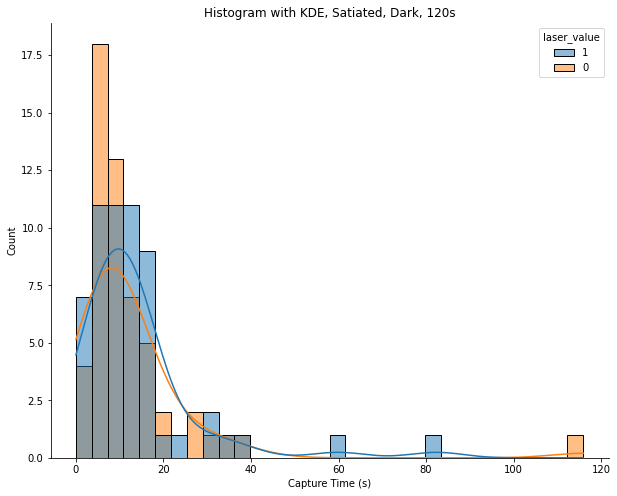

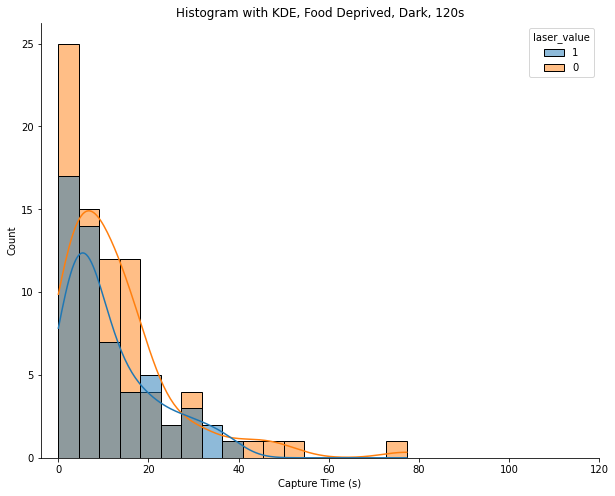

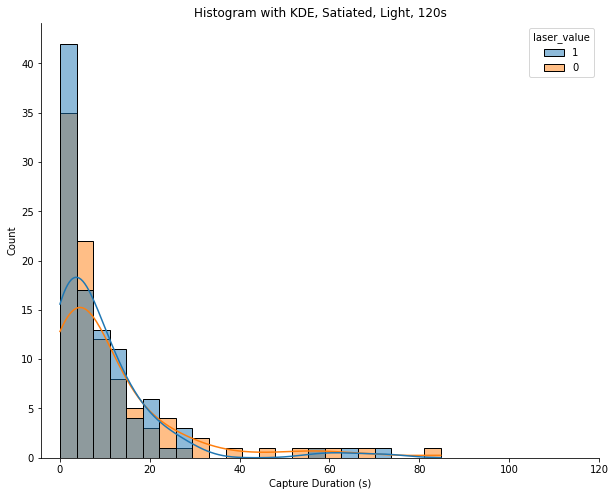

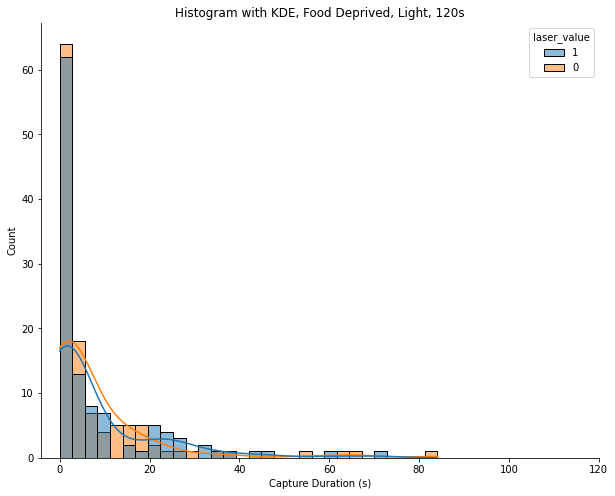

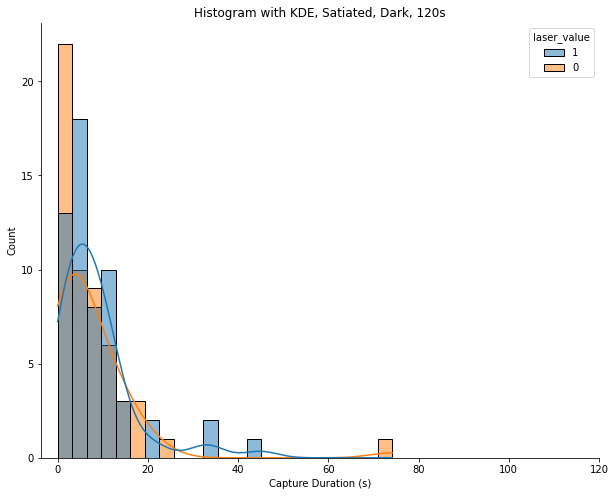

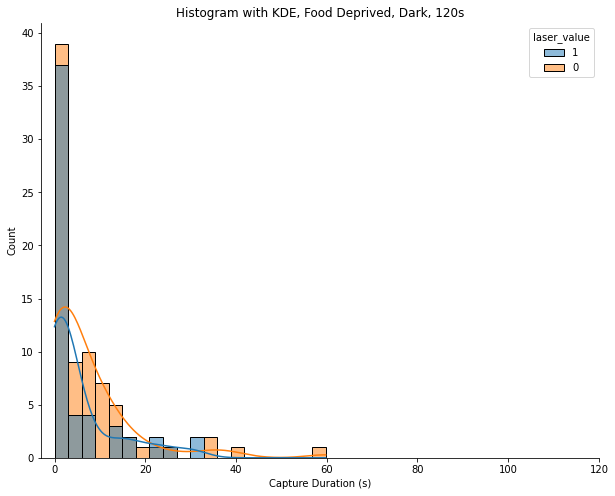

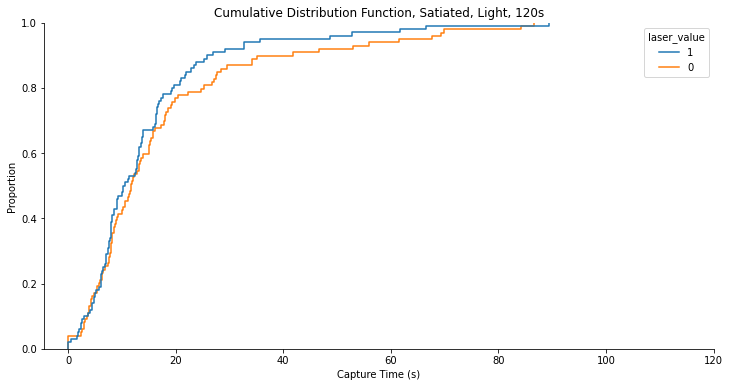

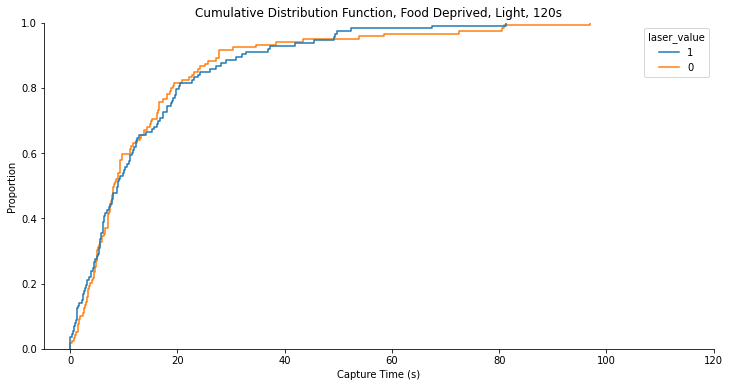

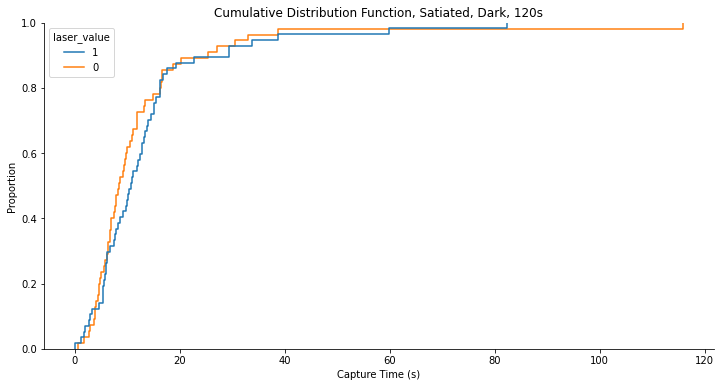

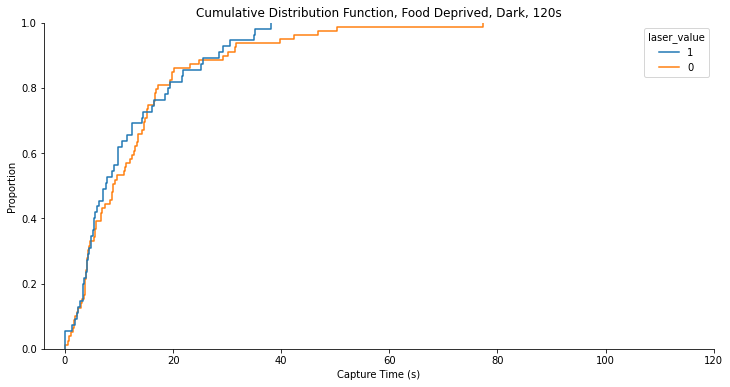

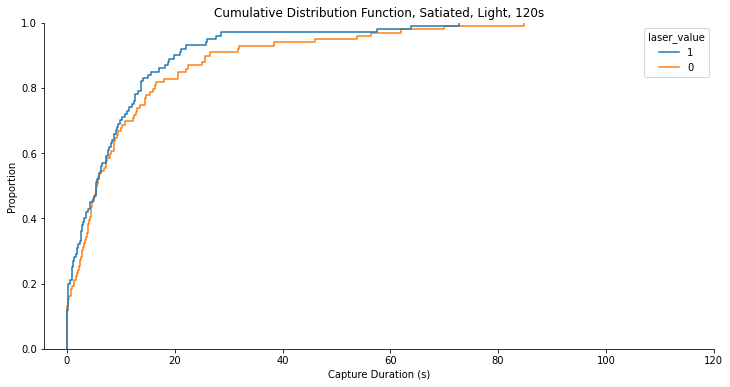

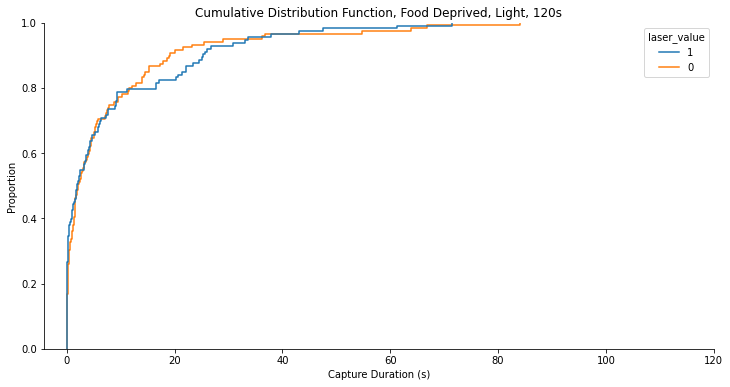

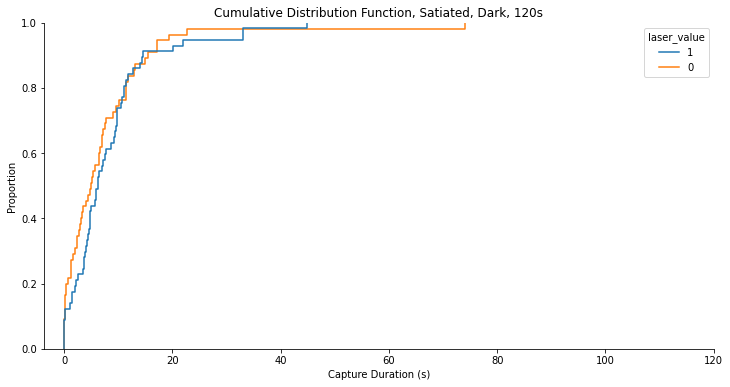

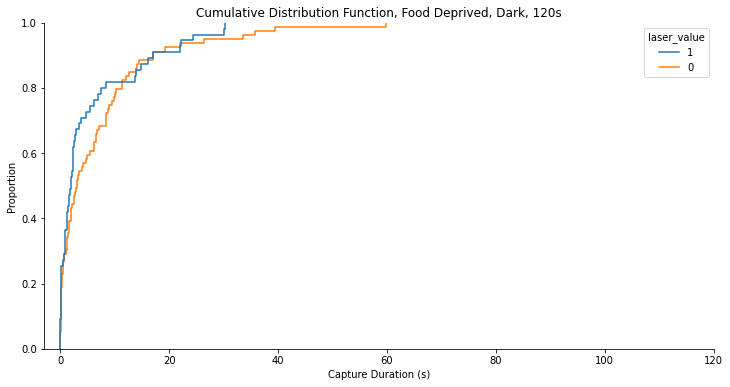

In [672]:
###TIME TO CAP KDE
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=newcond1_120, x='captureT', hue='laser_value', kde=True, hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Satiated, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedL120.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=newcond2_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Food Deprived, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepL120.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=newcond3_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Satiated, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_satiatedD120.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=newcond4_120, x='captureT', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Histogram with KDE, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capT_hist_fooddepD120.pdf')

###CAP DURATION KDE
fig1= plt.figure(figsize=(10,8))
sns.histplot(data=newcond1_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedL120.pdf')

fig2= plt.figure(figsize=(10,8))
sns.histplot(data=newcond2_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepL120.pdf')

fig3= plt.figure(figsize=(10,8))
sns.histplot(data=newcond3_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Satiated, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_satiatedD120.pdf')

fig4= plt.figure(figsize=(10,8))
sns.histplot(data=newcond4_120, x='capduration', hue='laser_value', kde=True,hue_order=hue_order)
# plt.xlim(0,120)
plt.xlabel('Capture Duration (s)')
plt.title('Histogram with KDE, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('/Users/mollyshallow/Desktop/Git/Prey_Capture_Python/figures/capduration_hist_fooddepD120.pdf')

##TIME TO CAP CDF
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond1_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capT_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond2_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capT_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond3_120, x='captureT', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capT_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond4_120, x='captureT', hue='laser_value', hue_order=hue_order)
plt.xlabel('Capture Time (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capT_fooddepD_120.pdf')

###CAP DURATION CDF
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond1_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capduration_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond2_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Light, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capduration_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond3_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Satiated, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capduration_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=newcond4_120, x='capduration', hue='laser_value',hue_order=hue_order)
plt.xlabel('Capture Duration (s)')
plt.title('Cumulative Distribution Function, Food Deprived, Dark, 120s')
plt.xticks(np.arange(0, 125,20))
sns.despine()
# plt.savefig('capduration_fooddepD_120.pdf')

<a id= 'Cricket-Survival-Rate' ></a>
## Plotting for cricket survival fraction.
###### return to [Table of Contents](#Table-of-Contents)

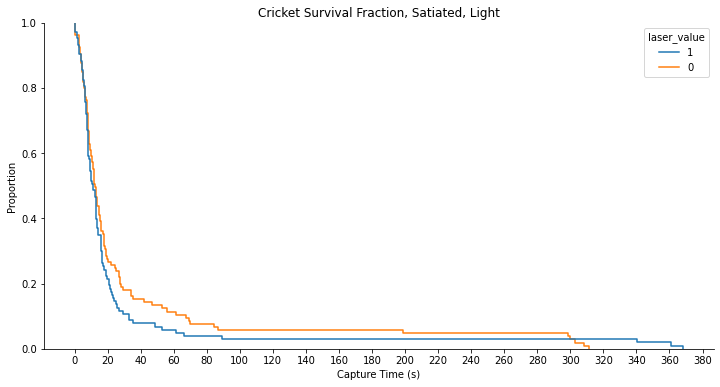

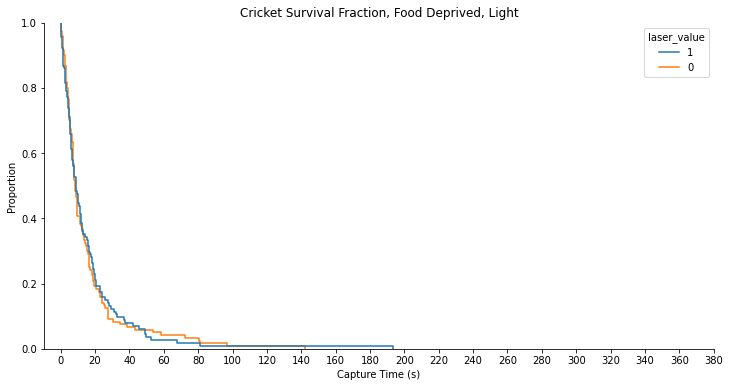

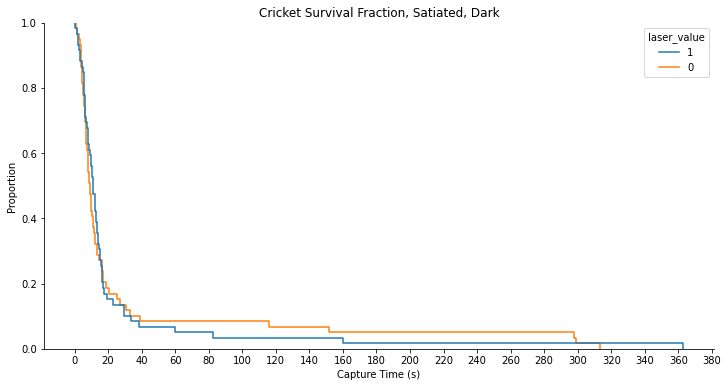

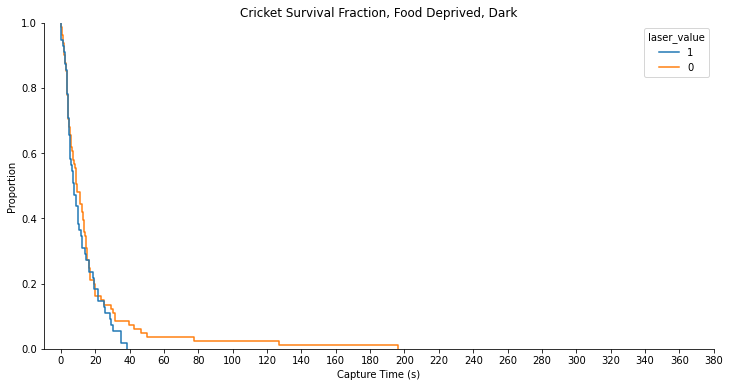

In [676]:

fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond1, x='captureT', hue='laser_value',hue_order=hue_order, complementary=True)
plt.xlabel('Capture Time (s)')
plt.title('Cricket Survival Fraction, Satiated, Light')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond2, x='captureT', hue='laser_value',hue_order=hue_order,complementary=True)
plt.xlabel('Capture Time (s)')
plt.title('Cricket Survival Fraction, Food Deprived, Light')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond3, x='captureT', hue='laser_value',hue_order=hue_order,complementary=True)
plt.xlabel('Capture Time (s)')
plt.title('Cricket Survival Fraction, Satiated, Dark')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond4, x='captureT', hue='laser_value',hue_order=hue_order, complementary=True)
plt.xlabel('Capture Time (s)')
plt.title('Cricket Survival Fraction, Food Deprived, Dark')
plt.xticks(np.arange(0, 400,20))
sns.despine()

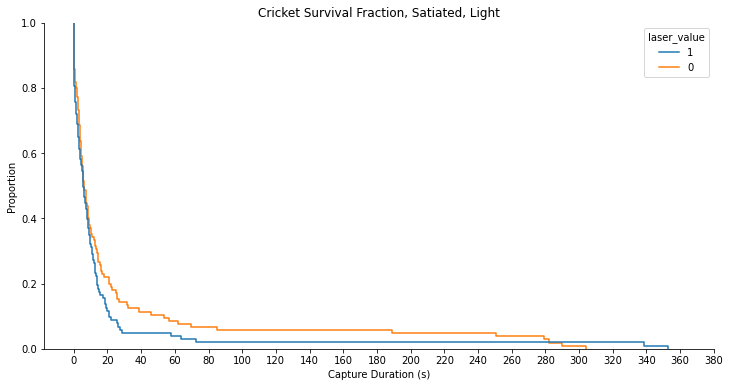

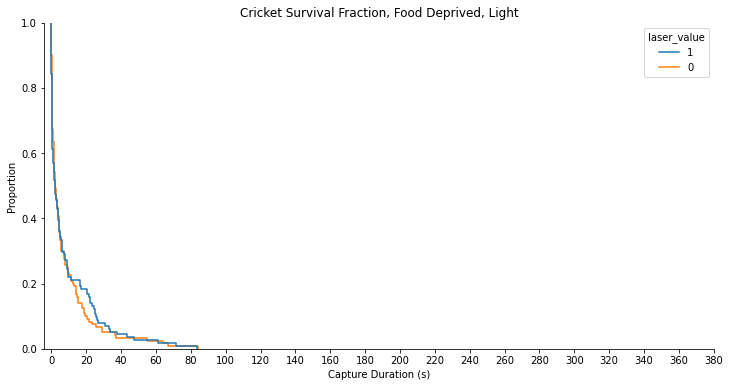

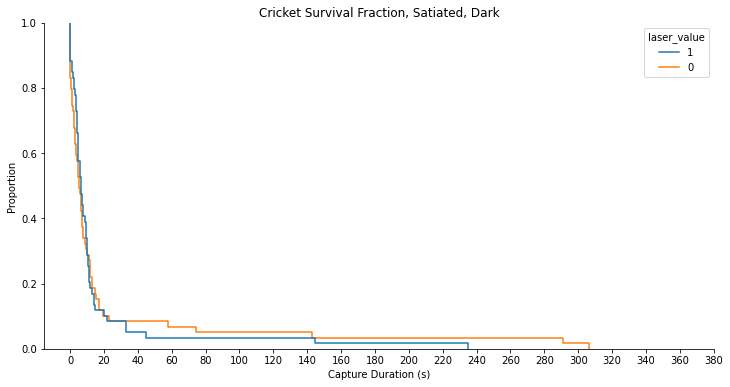

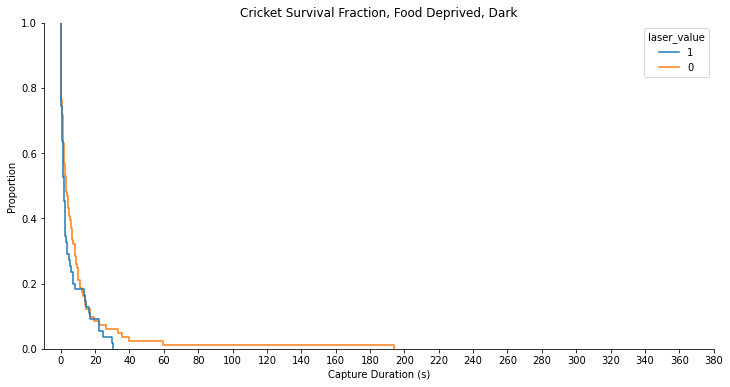

In [674]:
fig1= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond1, x='capduration', hue='laser_value',hue_order=hue_order, complementary=True)
plt.xlabel('Capture Duration (s)')
plt.title('Cricket Survival Fraction, Satiated, Light')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_satiatedL_120.pdf')

fig2= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond2, x='capduration', hue='laser_value',hue_order=hue_order,complementary=True)
plt.xlabel('Capture Duration (s)')
plt.title('Cricket Survival Fraction, Food Deprived, Light')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_fooddepL_120.pdf')

fig3= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond3, x='capduration', hue='laser_value',hue_order=hue_order,complementary=True)
plt.xlabel('Capture Duration (s)')
plt.title('Cricket Survival Fraction, Satiated, Dark')
plt.xticks(np.arange(0, 400,20))
sns.despine()
# plt.savefig('capT_satiatedD_120.pdf')

fig4= plt.figure(figsize=(12,6))
ax=sns.ecdfplot(data=allcond4, x='capduration', hue='laser_value',hue_order=hue_order, complementary=True)
plt.xlabel('Capture Duration (s)')
plt.title('Cricket Survival Fraction, Food Deprived, Dark')
plt.xticks(np.arange(0, 400,20))
sns.despine()

<a id= 'Stats' ></a>
# Statistics
###### return to [Table of Contents](#Table-of-Contents)

<a id= 'ANOVA' ></a>
## Messing around with some ANOVAs, not sure what any of them actually mean, or if this is the best way to deal with these data.
###### return to [Table of Contents](#Table-of-Contents)

In [211]:
statsdf=df[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]

#perform 2-way anova
model=ols('captureT ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf).fit()
sm.stats.anova_lm(model, typ=2)
          

,sum_sq,df,F,PR(>F)
C(condition),2.983846e+04,3.0,4.887215,0.002278
C(laser_value),3.911516e+03,1.0,1.921991,0.166086
C(condition):C(laser_value),2.489893e+03,3.0,0.407817,0.747433
Residual,1.400175e+06,688.0,NaN,NaN


In [208]:
#perform 2-way anova
model=ols('capduration ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),24622.039778,3.0,5.706472,0.000733
C(laser_value),3681.295642,1.0,2.559562,0.110088
C(condition):C(laser_value),3577.434297,3.0,0.829116,0.478069
Residual,989517.667441,688.0,NaN,NaN


In [213]:
#perform 2-way anova
model=ols('timetoapproach ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),143.323402,3.0,1.960499,0.118585
C(laser_value),4.621197,1.0,0.189638,0.663355
C(condition):C(laser_value),79.258752,3.0,1.084168,0.355060
Residual,16765.547650,688.0,NaN,NaN


In [214]:
#perform 2-way anova
model=ols('timetointercept ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),311.849043,3.0,0.278458,0.840965
C(laser_value),3.491046,1.0,0.009352,0.922989
C(condition):C(laser_value),355.612360,3.0,0.317535,0.812710
Residual,256833.782781,688.0,NaN,NaN


In [212]:
statsnandf=nandf[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]

#perform 2-way anova
model=ols('captureT ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsnandf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),5012.072685,3.0,1.814866,0.143077
C(laser_value),5057.748271,1.0,5.494216,0.019366
C(condition):C(laser_value),3472.632063,3.0,1.257436,0.288025
Residual,625979.870229,680.0,NaN,NaN


In [210]:
#perform 2-way anova
model=ols('capduration ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsnandf).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),5535.754301,3.0,2.877916,0.035338
C(laser_value),2892.898311,1.0,4.511861,0.034021
C(condition):C(laser_value),2969.637425,3.0,1.543849,0.201898
Residual,435999.887405,680.0,NaN,NaN


In [486]:
statsdf120=nandf_120[['condition','laser_value','captureT', 'capduration', 'timetoapproach','timetointercept']]

#perform 2-way anova
model=ols('captureT ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf120).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),1340.814528,3.0,1.978781,0.115841
C(laser_value),205.905168,1.0,0.911628,0.340028
C(condition):C(laser_value),364.628296,3.0,0.538120,0.656305
Residual,151103.955463,669.0,NaN,NaN


In [487]:
#perform 2-way anova
model=ols('capduration ~ C(condition) + C(laser_value) + C(condition):C(laser_value)', data=statsdf120).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),1304.878184,3.0,2.854199,0.036491
C(laser_value),98.225202,1.0,0.644553,0.422352
C(condition):C(laser_value),328.031279,3.0,0.717513,0.541727
Residual,101950.796496,669.0,NaN,NaN


<a id= 'KS-Test' ></a>
## Messing around with K-S tests for the cdf curves, not sure I'm doing this correctly, definitely a WiP.
###### return to [Table of Contents](#Table-of-Contents)

In [513]:
stats.kstest(cond1_off['captureT'], cond1_on['captureT'], 'norm', alternative='two-sided')

KstestResult(statistic=0.11206657420249654, pvalue=0.4780732237660811)

In [511]:
stats.ks_2samp(cond2_off['captureT'], cond2_on['captureT'])

KstestResult(statistic=0.07324561403508772, pvalue=0.8812437596275765)

In [508]:
stats.ks_2samp(cond3_off['captureT'], cond3_on['captureT'])

KstestResult(statistic=0.15254237288135594, pvalue=0.5020556560146455)

In [509]:
stats.ks_2samp(cond4_off['captureT'], cond4_on['captureT'])

KstestResult(statistic=0.11784511784511785, pvalue=0.6985253626226461)

#### Levene's test: tests for rejection of the null hypothesis that all samples come from equal distributions. 

In [733]:
stats.levene(cond1['captureT'], cond2['captureT'], cond3['captureT'], cond4['captureT'], center='trimmed')

LeveneResult(statistic=3.0441594200930004, pvalue=0.028324088331020455)

In [773]:
std_nandf=nandf.groupby(['condition','laser_value']).std()
temp=std_nandf[['captureT', 'capduration']]
std=pd.DataFrame(temp)
std=std.reset_index()
std

,condition,laser_value,captureT,capduration
0,Condition1,0.0,46.436242,44.655607
1,Condition1,1.0,14.017938,12.227214
2,Condition2,0.0,20.262468,13.747852
3,Condition2,1.0,22.238929,14.842068
4,Condition3,0.0,57.452564,42.706457
5,Condition3,1.0,23.551485,19.801795
6,Condition4,0.0,27.128040,23.110045
7,Condition4,1.0,9.960270,7.903817


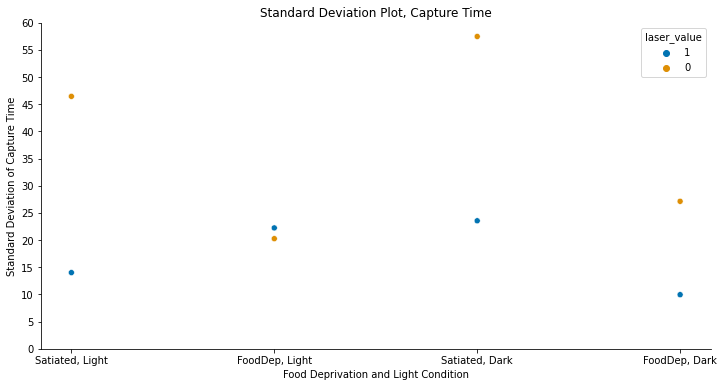

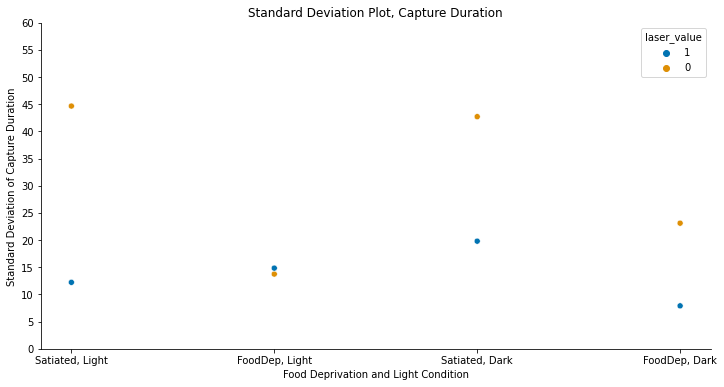

In [778]:
fig1= plt.figure(figsize=(12,6))
sns.scatterplot(data=std,x='condition', y='captureT', hue='laser_value', hue_order=hue_order, palette='colorblind')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.yticks(np.arange(0,65,5))
plt.ylabel('Standard Deviation of Capture Time')
plt.xlabel('Food Deprivation and Light Condition')
plt.title('Standard Deviation Plot, Capture Time')
sns.despine()

fig2= plt.figure(figsize=(12,6))
sns.scatterplot(data=std,x='condition', y='capduration', hue='laser_value', hue_order=hue_order, palette='colorblind')
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.yticks(np.arange(0,65,5))
plt.ylabel('Standard Deviation of Capture Duration')
plt.xlabel('Food Deprivation and Light Condition')
plt.title('Standard Deviation Plot, Capture Duration')
sns.despine()

In [779]:
sem_nandf=nandf.groupby(['condition','laser_value']).sem()
temp=sem_nandf[['captureT', 'capduration']]
sem=pd.DataFrame(temp)
sem=sem.reset_index()
sem

,condition,laser_value,captureT,capduration
0,Condition1,0.0,4.597873,4.421564
1,Condition1,1.0,1.401794,1.222721
2,Condition2,0.0,1.849702,1.255001
3,Condition2,1.0,2.082867,1.390087
4,Condition3,0.0,7.543891,5.607633
5,Condition3,1.0,3.092462,2.600103
6,Condition4,0.0,3.014227,2.567783
7,Condition4,1.0,1.343043,1.065750


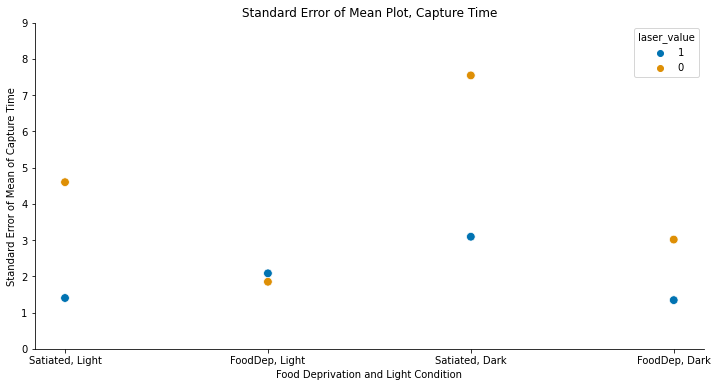

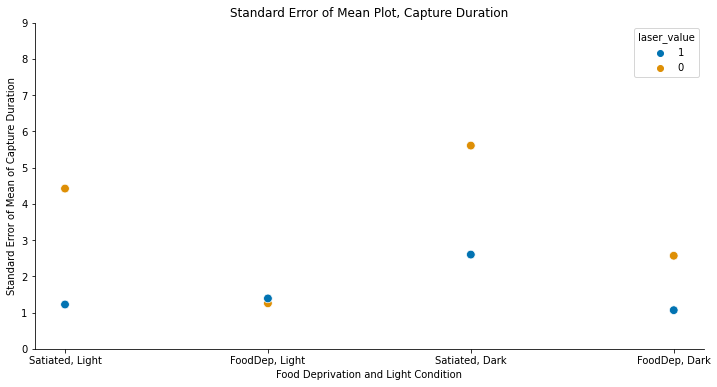

In [786]:
fig1= plt.figure(figsize=(12,6))
sns.scatterplot(data=sem,x='condition', y='captureT', hue='laser_value', hue_order=hue_order, palette='colorblind', s=75)
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.yticks(np.arange(0,10,1))
plt.ylabel('Standard Error of Mean of Capture Time')
plt.xlabel('Food Deprivation and Light Condition')
plt.title('Standard Error of Mean Plot, Capture Time')
sns.despine()

fig2= plt.figure(figsize=(12,6))
sns.scatterplot(data=sem,x='condition', y='capduration', hue='laser_value', hue_order=hue_order, palette='colorblind',s=75)
plt.xticks([0,1,2,3],['Satiated, Light', 'FoodDep, Light', 'Satiated, Dark', 'FoodDep, Dark'])
plt.yticks(np.arange(0,10,1))
plt.ylabel('Standard Error of Mean of Capture Duration')
plt.xlabel('Food Deprivation and Light Condition')
plt.title('Standard Error of Mean Plot, Capture Duration')
sns.despine()